In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('cubehelix')

import os

In [2]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_mpi = pd.read_csv("kiva_mpi_region_locations.csv")

In [3]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)

In [4]:
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders'] ]

**Определим в каких странах основными заемщиками были мужчины:**

In [5]:
df_gender_by_country_males = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male','female', 'group'], ascending = [True,False,False])[-15:]

df_gender_by_country_males = df_gender_by_country_males[['male','female','group']]

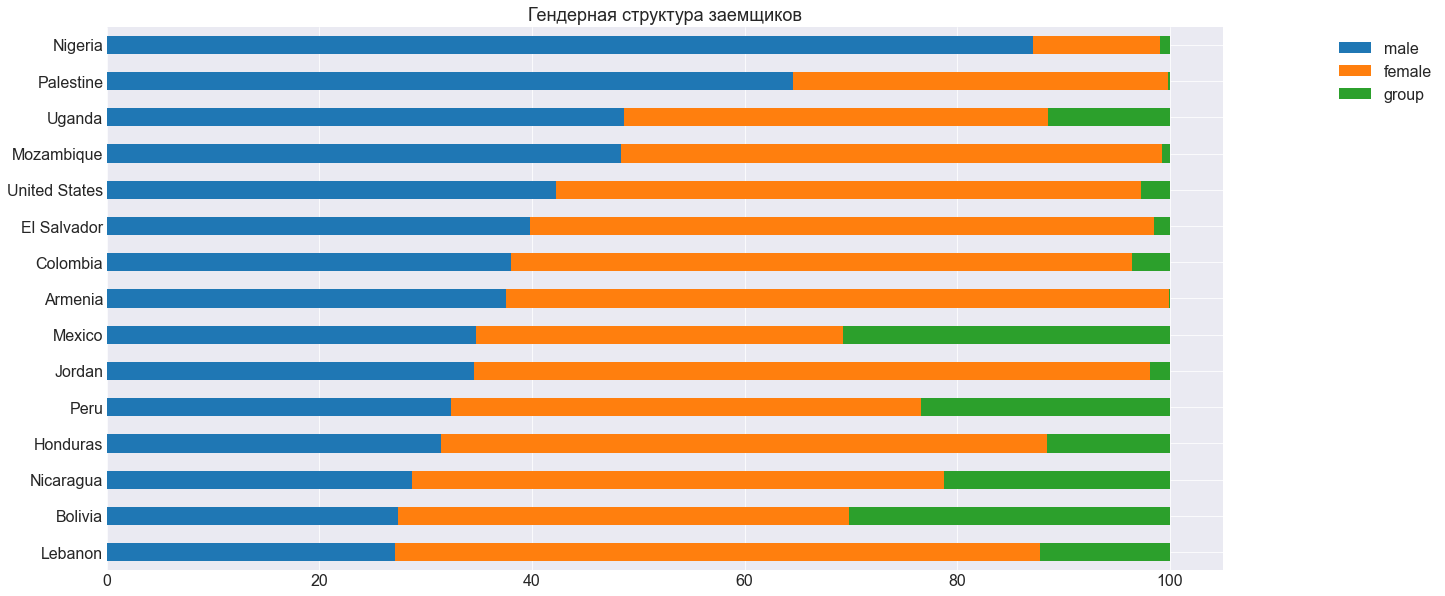

In [6]:
plot = df_gender_by_country_males.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

**Вывод:** Как видно по графику выше, мужчин-заемщиков больше чем женщин только в Нигерии, Палестине и Уганде. Как показывает беглый анализ особенностей данных стран, связано это скорее с такими факторами, как гендерная структура населения (в Нигерии и Палестине мужчин больше, чем женщин) а также вероисповедание и религиозно-бытовые убеждения (в Нигерии половина населения исповедует Ислам, а уклад традиционно патриархальный; в Уганде женщинам традиционно отводится роль домохозяйки). В приниципе, остальные страны в списке с самой крупной долей мужчин-заемщиков также характеризовались некоторой склонностью к патриархату. Удивляет только наличие в данном списке США. Однако распределение мужского и женского населения там практически 50 на 50,так что такая гендерная структура займов вполне имеет место быть.

**Определим в какие сектора были запрошены деньги мужчинами:**

In [7]:
sector_list_m= ['Nigeria', 'Palestine', 'Uganda', 'Mozambique','United States','El Salvador']
sector_m_df = df_kiva_loans[(df_kiva_loans['country'].isin(sector_list_m))]
male_sectors = sector_m_df['sector'].value_counts()

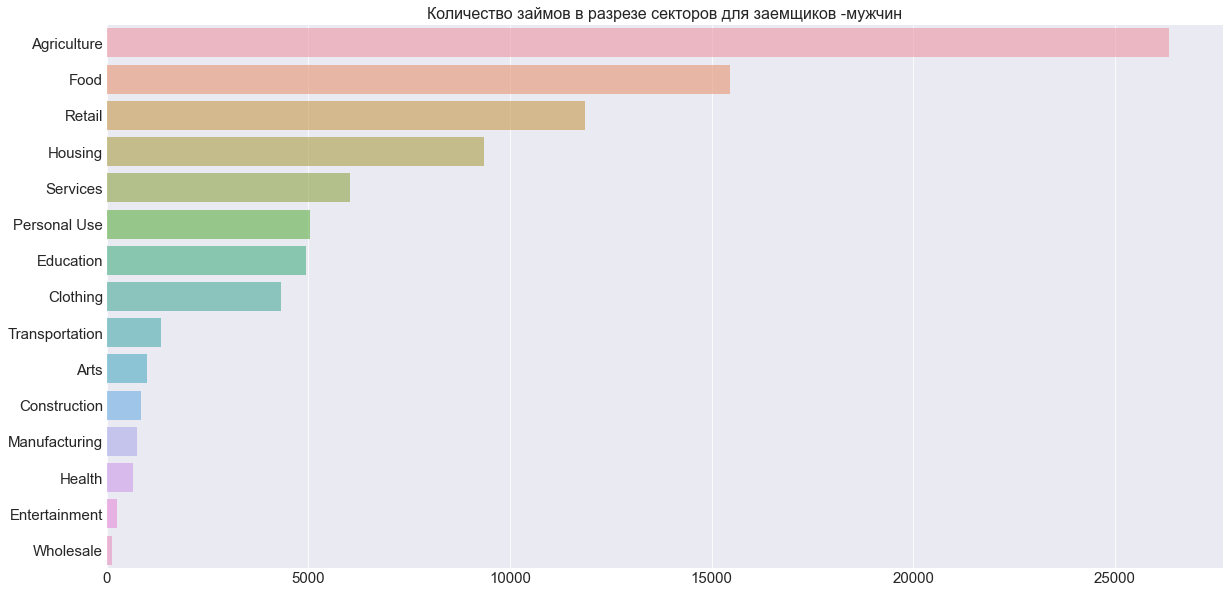

In [8]:
plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе секторов для заемщиков -мужчин", fontsize=16)
plt.tick_params(labelsize=15)
sns.barplot(y=male_sectors.index, x=male_sectors.values, alpha=0.6)
plt.show()

In [9]:
loans_by_activity_sector_m = \
    sector_m_df[sector_m_df['sector'].isin(male_sectors[:6].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

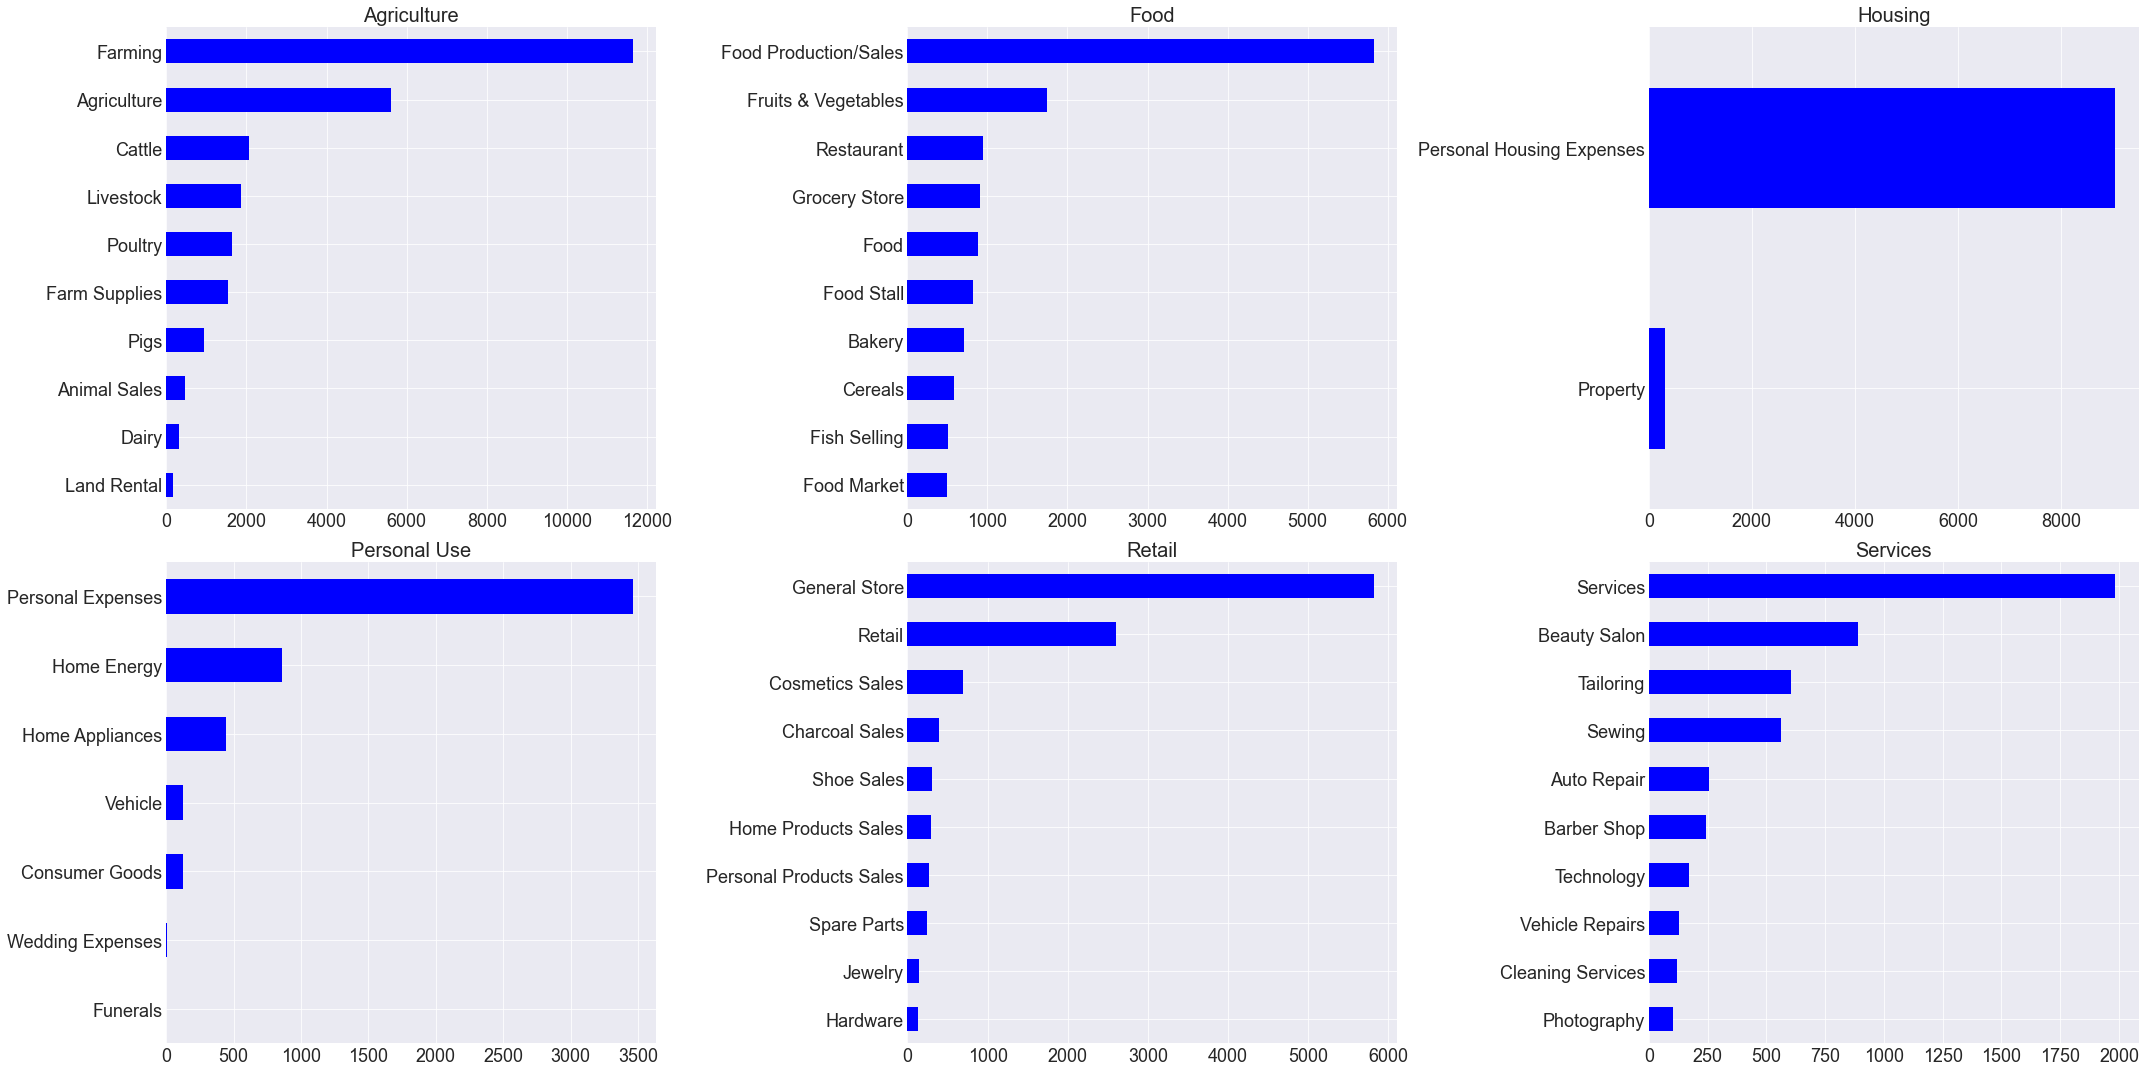

In [10]:
fig,axes = plt.subplots(2,3, sharex=False, squeeze=False, figsize=(30,15))

for ax,q in zip(axes.ravel(), loans_by_activity_sector_m.sector.unique()):
    tmp_df = loans_by_activity_sector_m[loans_by_activity_sector_m.sector.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-10:]
    ax.set_title(q, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='activity', ax=ax, legend=None, fontsize=18, color='b')

**Вывод:** Наибольшее количество заявок от мужского населения пришлось на такие сектора, как сельское хозяйство, далее - еда, розничная торговля, покупка жилья и оказание услуг. Кокретные выводы можно будет сделать в сравнении с аналогичными графиками для женского начеления.

**Проведем подобный анализ для стран, где большую часть займов запросили женщины.**

In [11]:
df_gender_by_country_f = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['female', 'male'])[-20:]

df_gender_by_country_f = df_gender_by_country_f[['female', 'male', 'group']]

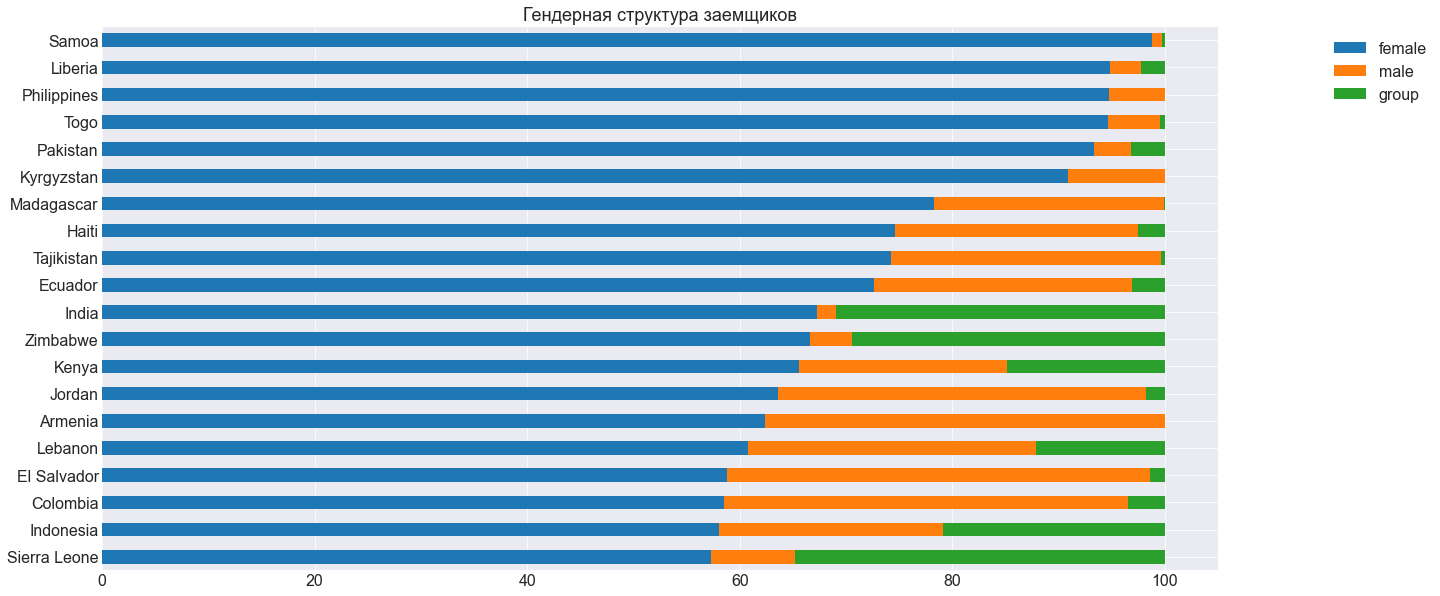

In [12]:
plot = df_gender_by_country_f.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [13]:
sector_list_f= df_gender_by_country_f.sort_values(by=['female', 'male'])[-20:].index.values
sector_f_df = df_kiva_loans[(df_kiva_loans['country'].isin(sector_list_f))]
female_sectors = sector_f_df['sector'].value_counts()

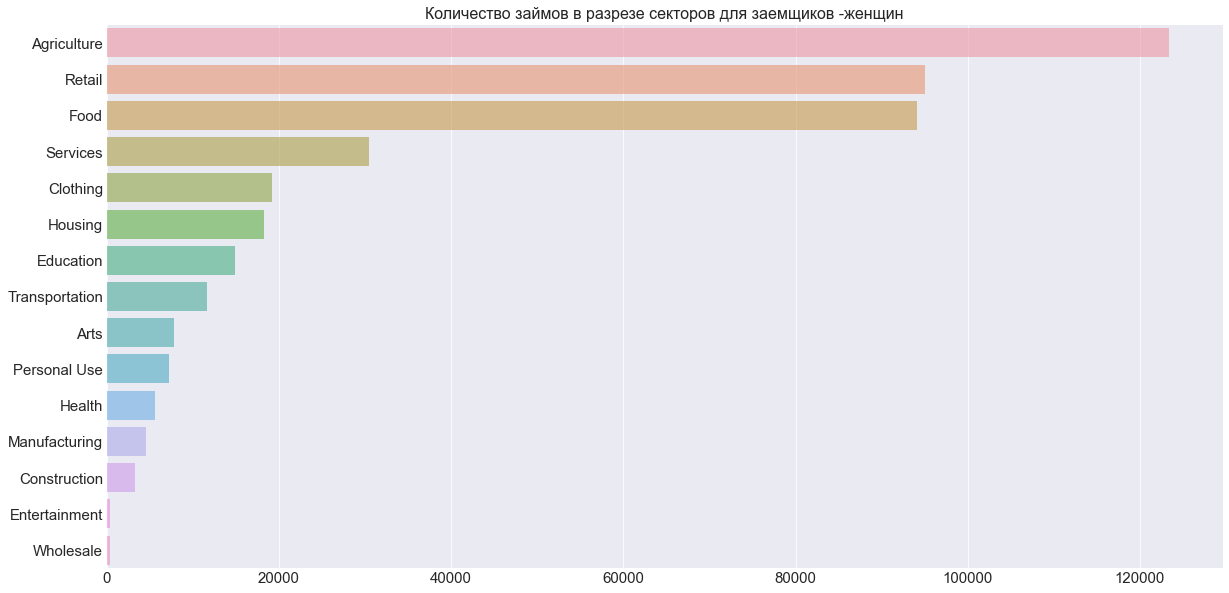

In [14]:
plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе секторов для заемщиков -женщин", fontsize=16)
plt.tick_params(labelsize=15)
sns.barplot(y=female_sectors.index, x=female_sectors.values, alpha=0.6)
plt.show()

In [15]:
loans_by_activity_sector_f = \
    sector_f_df[sector_f_df['sector'].isin(female_sectors[:6].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

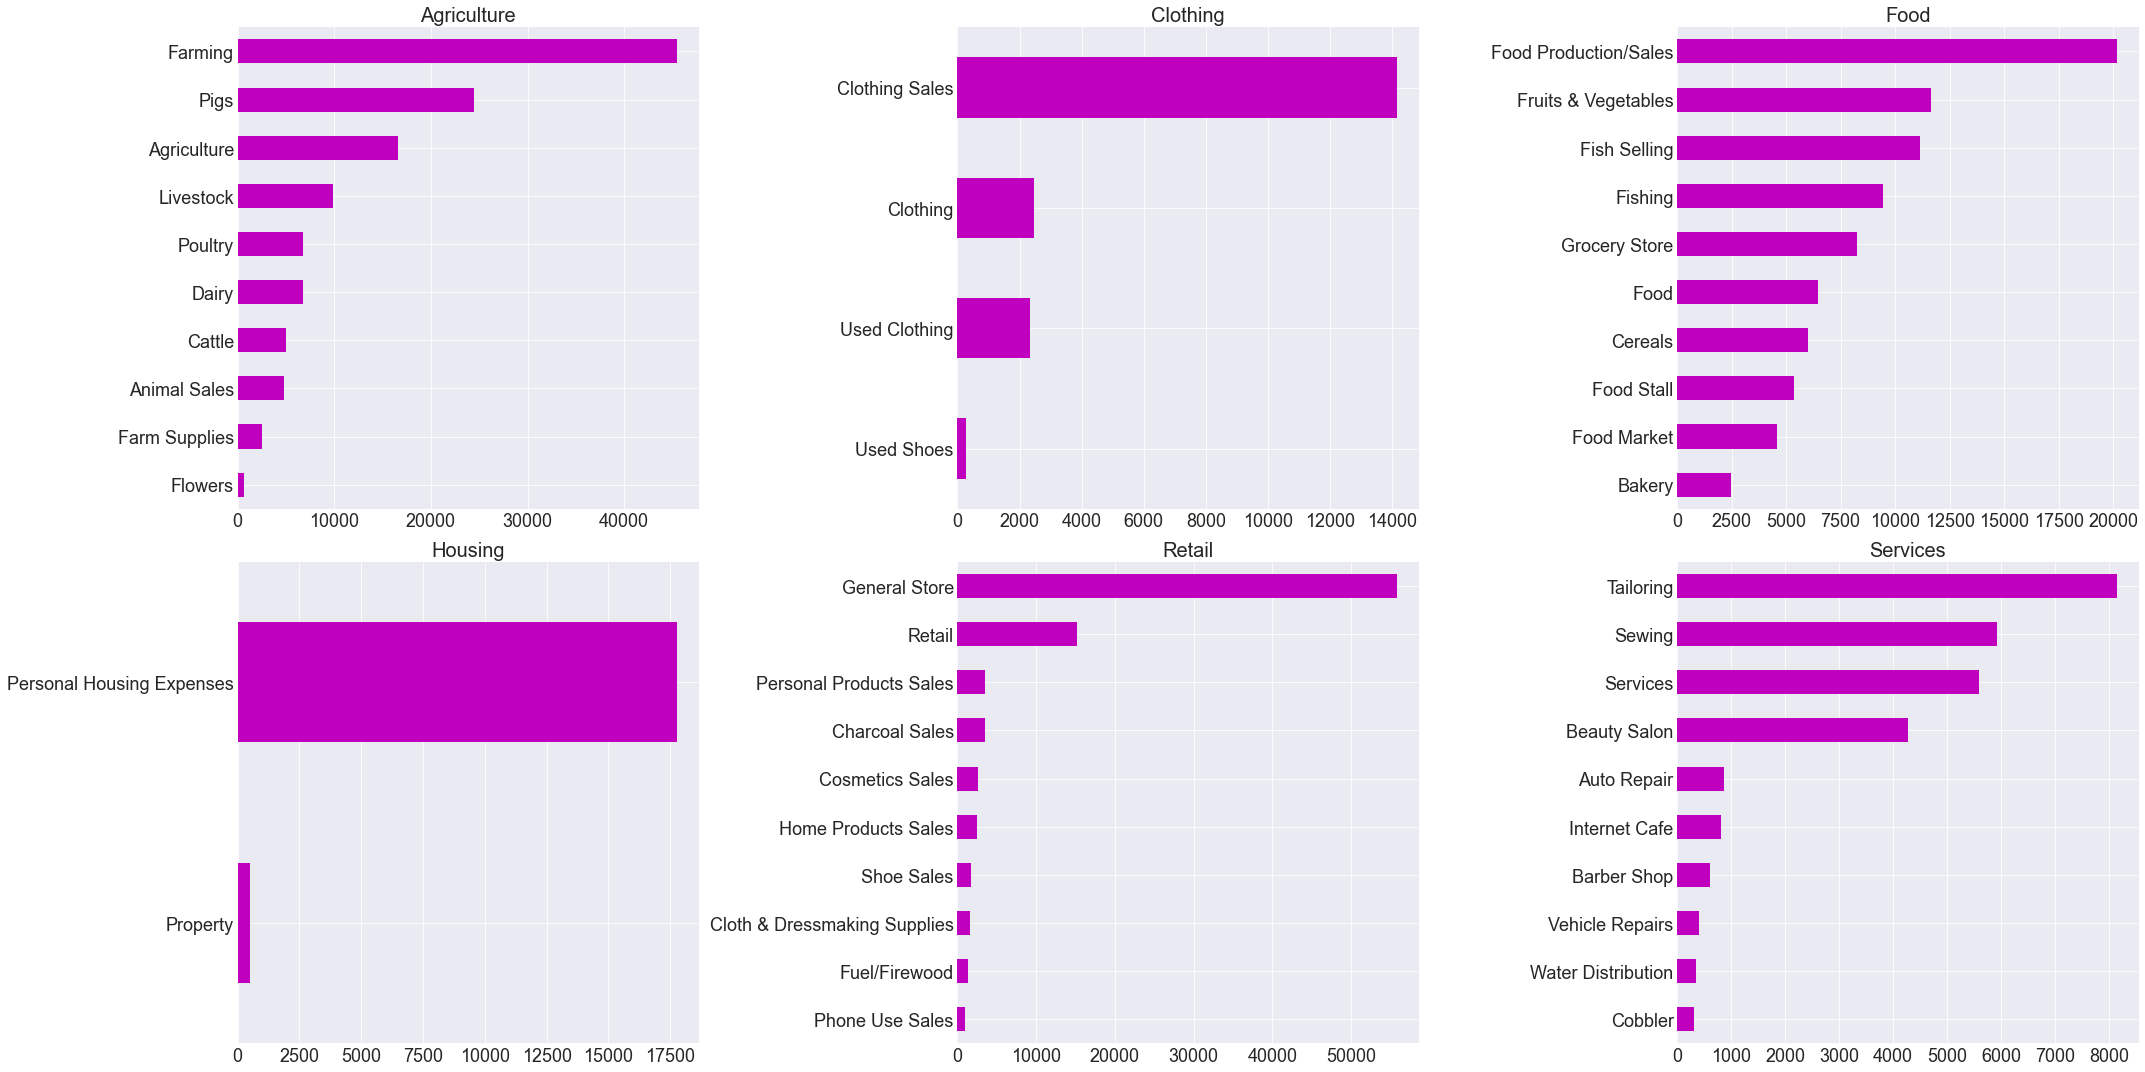

In [16]:
fig,axes = plt.subplots(2,3, sharex=False, squeeze=False, figsize=(30,15))

for ax,q in zip(axes.ravel(), loans_by_activity_sector_f.sector.unique()):
    tmp_df = loans_by_activity_sector_f[loans_by_activity_sector_f.sector.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-10:]
    ax.set_title(q, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='activity', ax=ax, legend=None, fontsize=18, color='m')

**Вывод:** Наибольшее количество зайвок от женского начеления пришлось на такие сектора, как сельское хозяйство, далее - розничная торговля, еда, оказание услуг и производство одежды.

Если сравнивать структуру заявок с заявками, сделанными мужчинами, можно обнаружить, что первая тройка позиций у них совпадает,  однако их соотношение разное. В общей сумме заявок у обеих гендерных групп неоспоримое лидерство удерживает сельскохозяйственная отрасль. У мужчин-заёмщиков доля запросов на сельское хозяйство составляет практически половину от всего количества займов. Для заемщиков женщин доля займов на эту отрасль была чуть меньше при намного большем общем количестве запросов - видно, что на гистограмме для заемщиков женщин займы на организацию розничных точек и производство/продажу пищевых продуктов также занимают достаточно значительную долю от общего количества займов. 

Таким образом, можно сделать вывод что при общем преобладании сельского хозяйства в структуре займов, для мужского населения эта отрасль имеет все же большее значение. Возможно в рассматриваемых странах мужское население традиционно занимается сельским хозяйством, в то время как женщины ведут домашнее хозяйство.

На втором и третьем месте ( в разных соотношениях) для обеих гендерных групп стоят займы на розничную торговлю и питание - тдостаточно простые для организации и прибыльные отрасли, не требующие постоянных крупных вложений, а лишь некоторого начального капитала на аренду места, закупку товаров/продуктов и налаживание их доставки.

Далее в структуре у разных групп наблюдаются расхождения. Для заемщиков мужчин крупную долю займов занимают займы на покупку жилья для частного использования, в то время как для женщин на первый план выходят займы на оказание услуг.
Затем в структуре займов среди мужксого населения выделяются займы на оказание услуг, для женщин - займы на сектор одежды, конкретнее на продажи (Clothing Sales). 

Стоит при этом отметить, что в структуре займов сектора оказания услуг для женщин выделяются займы на портняжное дело и шитье, т.е. можно отметить общее преобладание займов, связанных в целом с производством, починкой и шитьем одежды. С большой долей вероятности это вызвано традиционно женскими народными промыслами этих стран.

Также интересным фактом является положение в общей структуре займов на персональные нужды. В структуре для заемщиков-мужчин эти займы находятся на достаточно высокой позиции, в то время как для заемщиков-женщин они несущественны.


**Определим в каких странах основными заемщиками были группы:**

In [17]:
df_gender_by_country_group= \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group','male','female'], ascending = [True,False,False])[-15:]

df_gender_by_country_group = df_gender_by_country_group[['group','male','female']]

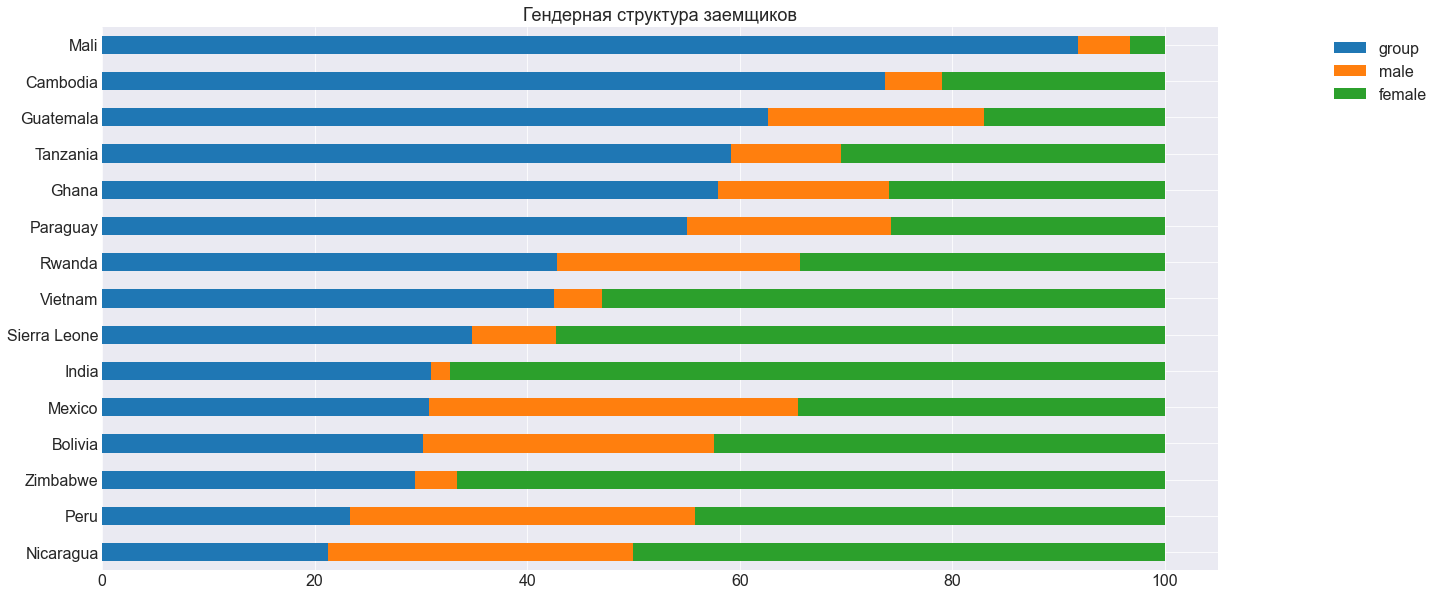

In [18]:
plot = df_gender_by_country_group.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

**Вывод:** Преобладание заемщиков групп-людей характерно для таких стран, как Мали, Камбоджа, Гватемала,Танзания, Гана, Парагвай и Рванда. Могу предположить, что это свзано с тем, что в данных странах преобладает сельскохозяйственный труд, обеспечивающий основную часть ВВП страны, а, соответсвенно, и основное направление занятости населения.Это вполне объясняло бы групповой характер займов, поскольку одной из особенностей сельского хозяйства является относительная сложность ведения в единоличном порядке (например, одному человеку не получится возделать большое количество земли, что очевидно). К тому же сельское хозяйство в бедных странах зачастую становится семейным (т.е опять же групповым) делом. 
Также сравнительный анализ данных стран показал, что часть из них относится к числу беднейших, в связи с чем могут потребоваться займы для семейных нужд.
Проверим данную информацию, изобразив графики по основным секторам и активностям, на которые потребовались займы в данных странах.

In [19]:
group_list= ['Mali', 'Cambodia', 'Guatemala', 'Tanzania','Ghana','Paraguay','Rwanda']
group_df = df_kiva_loans[(df_kiva_loans['country'].isin(group_list))]
group_sectors = group_df['sector'].value_counts()

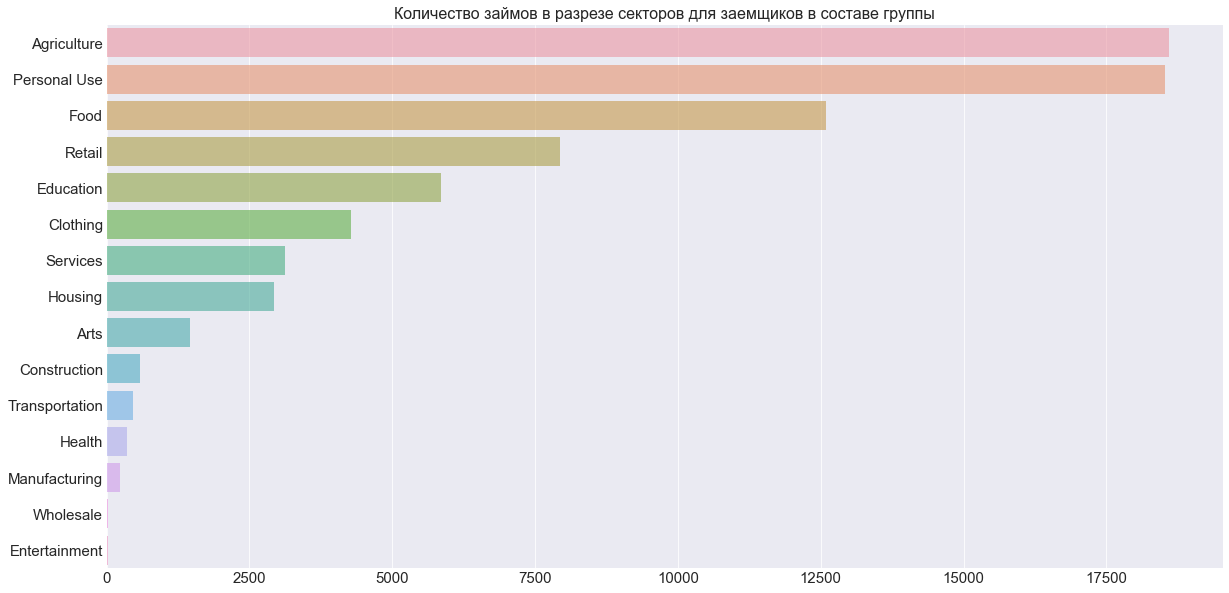

In [20]:
plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе секторов для заемщиков в составе группы", fontsize=16)
# plt.xlabel('Number of loans', fontsize=16)
# plt.ylabel("Sectors", fontsize=16)
plt.tick_params(labelsize=15)

sns.barplot(y=group_sectors.index, x=group_sectors.values, alpha=0.6)
plt.show()

**Вывод:** Данные диаграммы подтверждают выводы, сделанные выше. Займы группам людей требовались в первую очередь в секторе селского хозяйства, а также для персональных нужд. Помимо этого значительные займы потребовались для организации точек питания и розничных магазинов - это достаточно популярные способы заработка в подобных странах. Не удивляет и получение займов на образовательные нужды, т.к в условиях недостатка собственных средств такая статья займов вполне логична. Немного конкретизируем результат, показав основные затраты по каждому из 6 основных секторов.

In [21]:
loans_by_activity_sector_g = \
    group_df[group_df['sector'].isin(group_sectors[:6].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

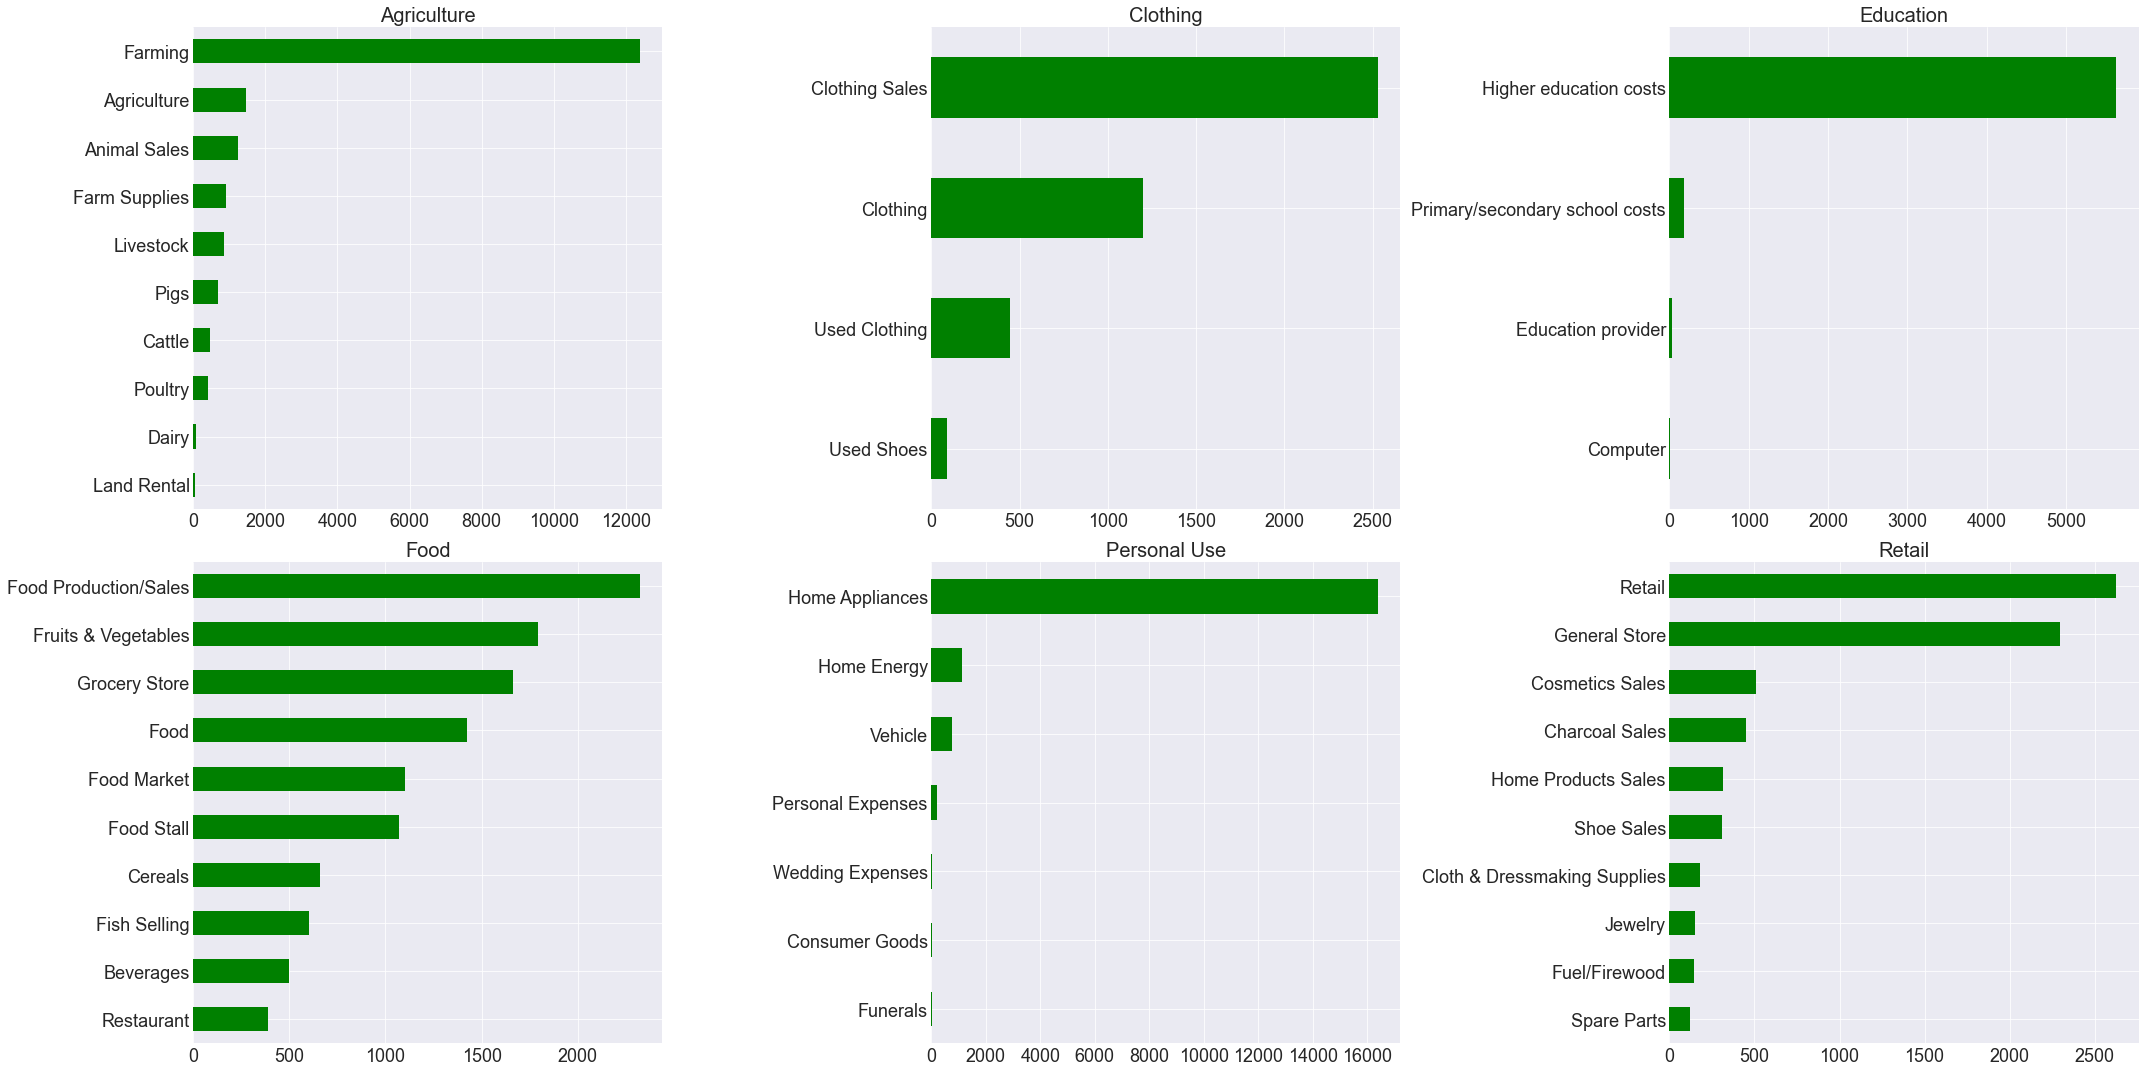

In [22]:
fig,axes = plt.subplots(2,3, sharex=False, squeeze=False, figsize=(30,15))

for ax,q in zip(axes.ravel(), loans_by_activity_sector_g.sector.unique()):
    tmp_df = loans_by_activity_sector_g[loans_by_activity_sector_g.sector.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-10:]
    ax.set_title(q, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='activity', ax=ax, legend=None, fontsize=18, color='g')

Не будем повторяться - диаграммы подтверждают сделанные ранее предположения.

**Проанализируем займы с большими суммами:**

*Для этого, прежде всего, отберем все займы свыше 20 т.долл.США*

In [23]:
df_kiva_loans_max = df_kiva_loans[df_kiva_loans['loan_amount']>= 20000]

*Определим на какие сектора попадают особо крупные займы:*

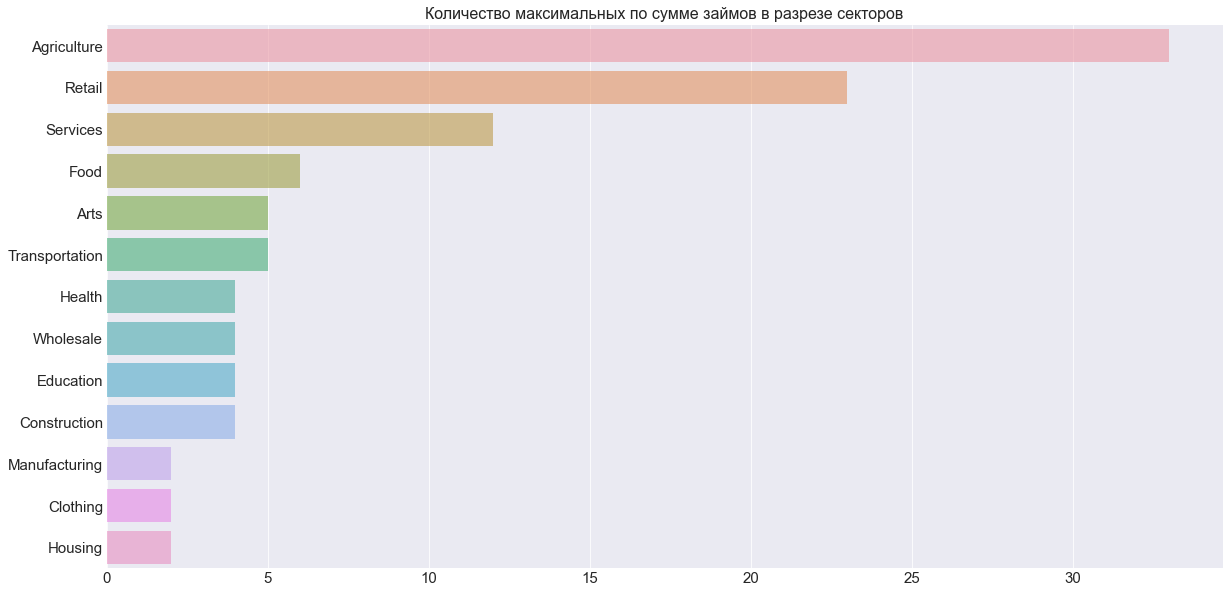

In [24]:
sectors_max = df_kiva_loans_max['sector'].value_counts()

plt.figure(figsize=(20,10))
plt.title("Количество максимальных по сумме займов в разрезе секторов", fontsize=16)

plt.tick_params(labelsize=15)

sns.barplot(y=sectors_max.index, x=sectors_max.values, alpha=0.6)
plt.show()

*Выявим из каких стран поступили запросы на крупные займы:* 

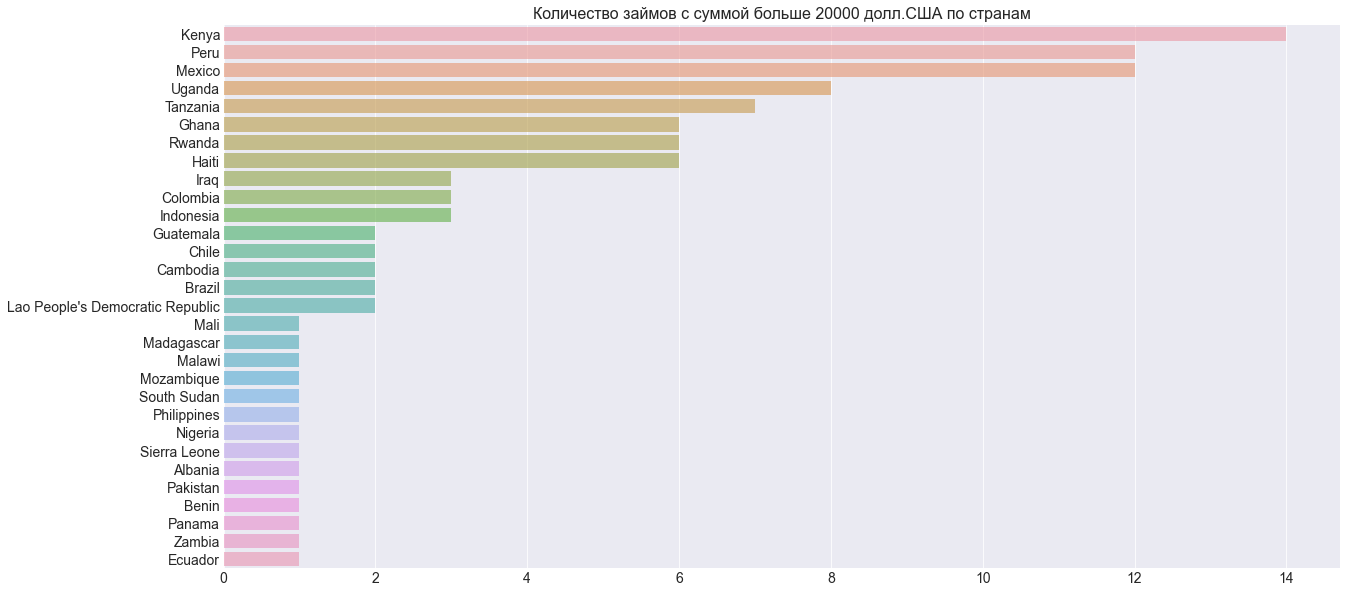

In [25]:
max_countries = df_kiva_loans_max['country'].value_counts().head(30)

plt.figure(figsize=(20,10))
plt.title("Количество займов c суммой больше 20000 долл.США по странам", fontsize=16)
plt.tick_params(labelsize=14)

sns.barplot(y=max_countries.index, x=max_countries.values, alpha=0.6)
plt.show()

*Определим половую структуру заемщиков подобных сумм:*

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


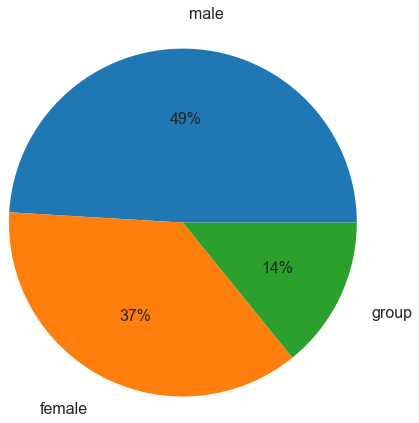

In [26]:
df_kiva_loans_max['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans_max['borrower_genders'] ]

borrowers_max = df_kiva_loans_max['borrower_genders'].value_counts()

plot = borrowers_max.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

*Изучим на что именно были направлены такие займы:*

In [27]:
activities_max = df_kiva_loans_max['use'].value_counts()

In [28]:
loans_by_activity_sector_max = \
    df_kiva_loans_max[df_kiva_loans_max['sector'].isin(sectors_max.index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

In [29]:
loans_by_activity_sector_max_sort=loans_by_activity_sector_max.sort_values(by='loan_amount', ascending = False)
loans_by_activity_sector_max_sort[:10]

,sector,activity,loan_amount
0,Agriculture,Agriculture,29
26,Retail,Renewable Energy Products,20
30,Services,Services,4
34,Transportation,Taxi,3
18,Health,Health,3
11,Education,Education provider,3
36,Wholesale,Goods Distribution,3
6,Arts,Weaving,2
15,Food,Food Production/Sales,2
20,Housing,Property,2


*И, наконец, посмотрим самые крупные по сумме займы детально:*

In [30]:
df_kiva_loans_max.sort_values(by='loan_amount')[-10:]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
507237,1167661,9975.0,50000.0,Fruits & Vegetables,Food,to generate income opportunities for 1250+ low...,PE,Peru,Lima,USD,429.0,2016-10-13 19:32:42+00:00,2016-11-11 08:00:00+00:00,NaN,60.0,224,"user_favorite, user_favorite, user_favorite, u...",male,irregular,2016-10-13
509048,1169175,50000.0,50000.0,Poultry,Agriculture,to purchase chicken feed & a delivery vehicle ...,TZ,Tanzania,Dar es Salaam,USD,497.0,2016-10-17 13:14:54+00:00,2016-12-31 08:00:00+00:00,2016-10-21 15:29:16+00:00,14.0,1765,"#Animals, #Woman Owned Biz, #Job Creator, #Biz...",female,irregular,2016-10-17
523634,1183609,50000.0,50000.0,Health,Health,"to mitigate CO2 & household air pollution, whi...",MW,Malawi,NaN,USD,431.0,2016-11-11 11:12:32+00:00,2017-02-03 08:00:00+00:00,2016-11-21 19:33:23+00:00,24.0,1465,"#Health and Sanitation, user_favorite, #Eco-fr...",male,irregular,2016-11-11
523659,1183916,50000.0,50000.0,Electronics Sales,Retail,to train & equip 200 rural merchants in Mozamb...,MZ,Mozambique,Maputo,USD,492.0,2016-11-12 02:45:29+00:00,2016-12-31 08:00:00+00:00,2016-12-18 14:10:28+00:00,14.0,1410,"#Biz Durable Asset, #Technology, #Job Creator,...",female,irregular,2016-11-12
526100,1186897,50000.0,50000.0,Renewable Energy Products,Retail,to distribute 200+ innovative & affordable pay...,ZM,Zambia,Lusaka,USD,503.0,2016-11-17 13:43:28+00:00,2016-12-31 08:00:00+00:00,2016-11-20 22:18:00+00:00,14.0,1550,"#Technology, #Eco-friendly, #Job Creator, user...",male,irregular,2016-11-17
538248,1198658,50000.0,50000.0,Agriculture,Agriculture,"to enable 5,000 additional small-holder farmer...",KE,Kenya,Nanyuki,USD,505.0,2016-12-05 15:00:24+00:00,2017-01-31 08:00:00+00:00,2016-12-19 23:47:20+00:00,14.0,1589,"user_favorite, user_favorite, #Eco-friendly, #...",male,monthly,2016-12-05
540849,1201692,0.0,50000.0,Goods Distribution,Wholesale,NaN,HT,Haiti,NaN,USD,506.0,2016-12-09 22:54:50+00:00,2017-02-28 08:00:00+00:00,NaN,14.0,0,NaN,group,irregular,2016-12-09
490191,1150277,50000.0,50000.0,Health,Health,To purchase raw materials in order to produce ...,GH,Ghana,Accra,USD,489.0,2016-09-14 13:03:24+00:00,2016-11-30 08:00:00+00:00,2016-09-19 20:06:54+00:00,14.0,1569,"#Health and Sanitation, #Biz Durable Asset, #E...",male,irregular,2016-09-14
494470,1154951,50000.0,50000.0,Agriculture,Agriculture,To pay smallholder coffee farmers in rural Ken...,KE,Kenya,Nairobi,USD,491.0,2016-09-21 19:31:42+00:00,2016-11-30 08:00:00+00:00,2016-10-17 22:37:04+00:00,15.0,1441,"#Woman Owned Biz, #Sustainable Ag, #Woman Owne...",female,irregular,2016-09-21
70499,722883,100000.0,100000.0,Agriculture,Agriculture,create more than 300 jobs for women and farmer...,HT,Haiti,Les Cayes,USD,315.0,2014-06-10 19:25:02+00:00,2014-09-08 07:00:00+00:00,2014-06-19 20:21:04+00:00,75.0,2986,"user_favorite, user_favorite, user_favorite, u...",female,irregular,2014-06-10


**Вывод:** После детального рассмотрения всех займов с особо крупной суммой можно сделать следующие умозаключения.  
Во-первых, займы в особо крупной сумме требуются в первую очередь для следуюших секторов: сельское хозяйство (безусловный лидер), розничная торговля, оказание услуг и организация точек питания.  
Если говорить про конкретные цели приобретения, то больше всего запросов было на создание новых рабочих мест (сельхоз проекты), возобновляемые источники энергии (для розницы), а также для покупки оборудования и машин (в первую очередь для организации такси-перевозок).  
Также крупные суммы шли на санитарно-гигиенические и здравоохранительные нужды (Health) и для образовательных целей (Education). Замыкают основную десятку крупных займов суммы, направленнве на организацию поставки товаров для оптовой торговли, поддержку народного промысла (ткачество), производство и продажу продуктов питания, а также на покупку жилья.  
В части половой структуры наиболее крупных сумм займов можно сделать следующие выводы: 
Практически половина таких займов была запрошена мужчинами, далее, около 37% приходится на женщин, и, наконец, порядка 14% - на группу людей. 

**Попробуем найти зависимость пола заёмщика от региона планеты.**

*Примечание: зависимость пола заемщика и сектора займа уже была рассмотрена нами выше.*

In [31]:
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

In [32]:
df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')

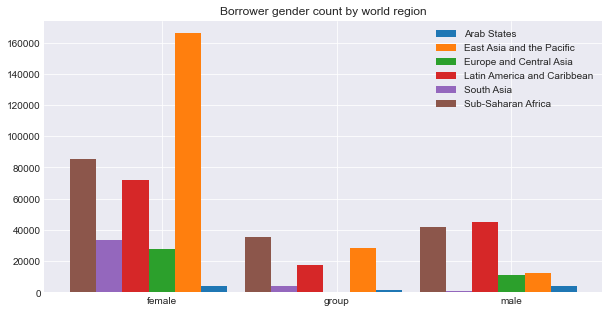

In [33]:
plt.figure(figsize=(10, 5))
x = np.asarray([0, 1, 2])
width = 0.15
i = -2
for name, group in df_kiva_loans.groupby(['world_region']):
    plt.bar(x - i*width, group.groupby('borrower_genders').size().values, width, label=name)
    i += 1
plt.title('Borrower gender count by world region')
plt.xticks(x, list(df_kiva_loans.groupby('borrower_genders').groups.keys()))
plt.legend()
plt.show()

**Вывод:** Столбчатая диаграмма с разбивкой по региону планеты в очередной раз доказывает лидиующее положение заявок от женщин в общей структуре заявок Kiva - во всех регионах заявки от женщин занимают лидирующую позицию.    
Как видно из диаграммы, наибольшую долю от всех заявок занимают заявки, сделанные в Восточной Азии и Тихоокеанском регионе. 
Далее следуют страны субсахарской Африки, Латинская Америка и страны Карибского региона, Южная Азия, Европа и Центральная Азия и, наконец, Арабские страны. Таким образом брольшая часть запросов поступает от регионов с наибольим количеством бедного населения, что неудивительно.   
Подробнее рассмотртим регионально-гендерное распределение заявок.   
Значительная часть заявок от женщин пришла из стран Восточной Азии и Тихоокеанского региона. Почти вдвое меньше заявок пришло из Африки, еще чуть меньше - из Латинской Америки и Каррибского региона. Чуть больше 20 тыс. заявок поступило от женщин из Южной Азии, а также Европы и Ценральной Азии.   
Для заявок от групп распределение немного другое. Большее количество заявок поступило из стран Африки (около 36 тыс.), далее следует количество заявок от групп заявщиков Восточной Азии и Тихоокеанского региона (порядка 24 тыс.), а затем из стран Латинской Америки и Каррибского региона.Что примечательно, для данной гендерной группы практически не было заявок из стран Европы и Центральной Азии, а количество заявок из Южной Азии было совсем незначительным.   
В структуре регионов мужчин-заявщиков наибольшее количество заявок составили заявки из Лат.Америки и Африки (чуть больше 40 тыс. для обоих регионов). Около 10 тыс. заявок от мужчин пришлось на регионы Восточной Азии, а также Европы и Центральной Азии. Заявки из Южной Азии при этом практически отсутствовали.  
Заявки из Арабских стран составили меньше всего от общей доли заявок, что скорее всего связано с тем, что уровень бедности в этом регионе в общем ниже, чем в остальных регионах.

**Влияние такого атрибута займа, как «Количество кредиторов» (lender_count) на суммы и сроки займов:**

*Отфильтруем исходный набор данных по сумме:*

In [34]:
# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

*Посмотрим какие значения есть в исходном урезанном датафрейме:*

In [35]:
df_kiva_loans_trimmed.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,MPI
count,6.558530e+05,655853.000000,655853.000000,645639.000000,655853.000000,655853.000000,584691.000000
mean,9.928668e+05,673.635510,715.067820,178.867366,13.649405,18.594572,0.130255
std,1.968290e+05,680.983224,704.620596,94.068243,8.245540,18.947711,0.117405
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000,0.000000
25%,8.224450e+05,250.000000,275.000000,126.000000,8.000000,7.000000,0.053080
50%,9.915990e+05,450.000000,475.000000,145.000000,13.000000,12.000000,0.061824
75%,1.163975e+06,850.000000,925.000000,204.000000,14.000000,23.000000,0.209375
max,1.340339e+06,4425.000000,4425.000000,533.000000,141.000000,268.000000,0.549778


*Минимальное число заемщиков в датафрейме равно нулю, что невозможно. Это значит, что 0 - это значение, которое ставится по умолчанию, если не указано иное. Изучим подробно совокупность займов с нулевой суммой заемщиков, чтобы определить как следует действовать дальше.*

In [36]:
zeroes = df_kiva_loans_trimmed[df_kiva_loans_trimmed['lender_count'] == 0]

In [37]:
zeroes.head(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,ISO,world_region,MPI
13542,1080465,0.0,1500.0,Crafts,Arts,"increase my inventory of handmade candles, dri...",US,United States,NaN,USD,...,NaN,12.0,0,NaN,male,bullet,2014-02-06,NaN,NaN,NaN
23206,1080586,0.0,2500.0,Services,Services,reach and help more people via my consulting b...,US,United States,NaN,USD,...,NaN,12.0,0,NaN,female,bullet,2014-02-25,NaN,NaN,NaN
26586,1080630,0.0,3500.0,Food Production/Sales,Food,"purchase health permits, peddlers permit, stre...",US,United States,NaN,USD,...,NaN,24.0,0,NaN,male,bullet,2014-03-05,NaN,NaN,NaN
36075,688991,0.0,600.0,Personal Medical Expenses,Health,NaN,BO,Bolivia,NaN,USD,...,NaN,20.0,0,NaN,group,monthly,2014-03-25,NaN,NaN,NaN
36611,1080840,0.0,4000.0,Education provider,Education,complete my website and purchase materials for...,US,United States,NaN,USD,...,NaN,24.0,0,NaN,female,bullet,2014-03-26,NaN,NaN,NaN


In [38]:
zeroes['borrower_genders'].unique()

array(['male', 'female', 'group'], dtype=object)

*Подробнее изучим, на что были направлены займы для Группы с нулевым значением заемщиков*

In [39]:
zeroes[zeroes['borrower_genders'] == 'group']['use'].unique()

array([nan,
       'to purchase hybrid seeds and fertilizer to improve harvests of maize\t\t\t\t\t\t\t',
       'to pay for plowing fees to support her farming business.',
       'to buy more rice seed and fertilizer to use on her rice farmland so it will grow well.',
       'to buy seed, fertilizer and sump to improve her farmland',
       'to buy fertilizer and seeds to grow her crops well.',
       'to buy more chilies for her growing. ',
       'to buy farming supplies and other basic household items.',
       'to buy more seed and pay a plowing fee to improve yield on her corn farmland.',
       'to pay for their plowing fee.',
       ' to buy seed, fertilizer and pesticide for her farmland',
       'to buy more corn seed and pay plowing fees to improve her corn farmland and its yield.',
       "to use on his farm as well as help to support his daughter's business.",
       ' to prepare her farmland for growing peanuts.',
       ' to buy fertilizer and pesticides for her farmland'

*Итак, в столбце с целями использования для Группы с необозначенным числом заемщиков чаще всего встречаются слова 'her', 'his', что гооворит о том, что займ был получен все-таки единоличным заемщиком.Примем это к сведению для дальнейшего исследования*

*Чтобы построить диаграмму с усиками, разобьем данные на группы по количеству заемщиков.  
   Для этого изучим распределение сумм в столбце 'lender_count': минимум, процентили, максимум. В связи с этим были выбраны группы значений: 0 (минимум), 1 (самое распространенное значение, судя по тому, что большее число займов получали женщины и мужчины, а не группы), 2-7 (25% процентиль), 8-12(50% процентиль), 24-100, 100-200 и больше 201.  
   После изучения описания к займам, где количество заемщиков равно нулю, становится понятно, что как минимум 90% этих займов получены одним заемщиком, так что отнесем их к группе '1'*

In [40]:
def group_lenders(x):
    if x == 0:
        y = '1'
    elif x == 1:
        y = '1'
    elif x<=7:
        y = '2-7'
    elif 7<x<=12:
        y = '8-12'
    elif 12<x<=23:
        y = '13-23'
    elif 23<x<=100:
        y = '24-100'
    elif 100<x<=200:
        y = '101-200'
    else:
        y = '>201'
    return y

In [41]:
df_kiva_loans_trimmed['lender_count_group'] = df_kiva_loans_trimmed['lender_count'].apply(group_lenders)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


*Поскольку мы будем полностью менять порядок данных для построения зависимости количества кредиторв от суммы займов, создадим копию исходного датафрейма*

In [42]:
df_sorted = df_kiva_loans_trimmed.copy()

In [43]:
sorted_val = ['0','1','2-7','8-12','13-23', '24-100','101-200','>201']
sorted_valIndex = dict(zip(sorted_val,range(len(sorted_val))))
df_sorted['group_position'] = df_sorted['lender_count_group'].map(sorted_valIndex)

In [44]:
df_sorted.sort_values(by = 'group_position',inplace=True)

*Найдем также медианные значения по группам:*

In [99]:
df_sum_median = df_sorted\
   .groupby(['lender_count_group'])['loan_amount']\
   .agg(median = 'median')
df_sum_median['group_position'] = df_sum_median.index.map(sorted_valIndex)
df_sum_median.sort_values(by = 'group_position',inplace=True)
df_sum_median

,median,group_position
lender_count_group,,
1,250.0,1
2-7,200.0,2
8-12,300.0,3
13-23,550.0,4
24-100,1175.0,5
101-200,3525.0,6
>201,4000.0,7


*Построим график по всем значениям:*

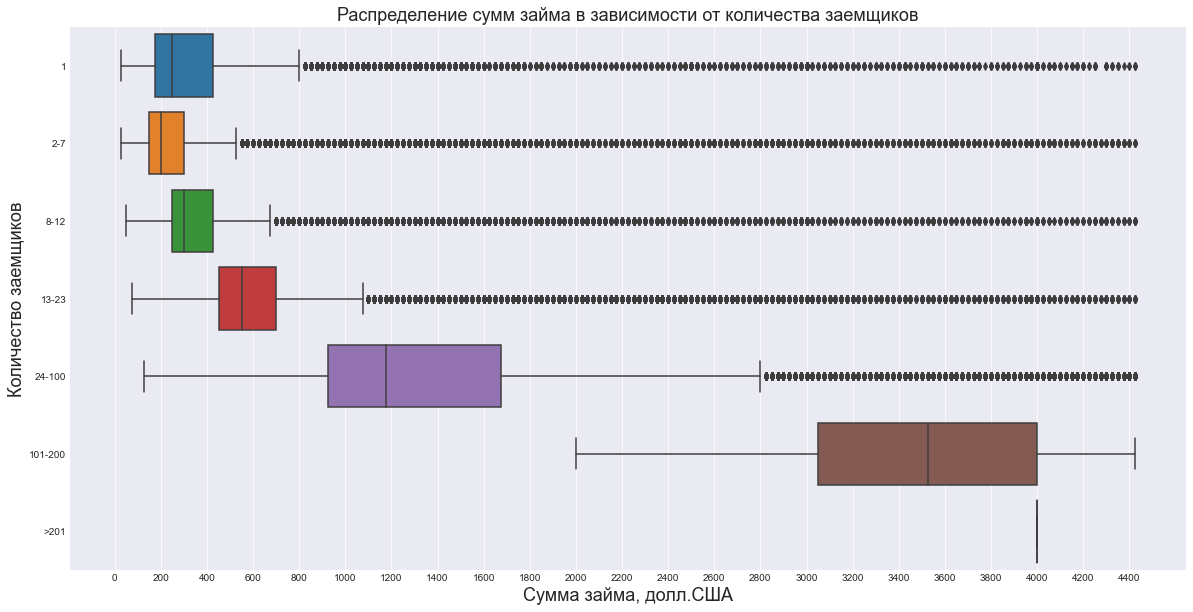

In [46]:
plt.figure(figsize=(20,10))
plt.title("Распределение сумм займа в зависимости от количества заемщиков", fontsize=18)
plt.xticks(np.arange(0, max(df_sorted['loan_amount']+100), 200))
b = sns.boxplot(x='loan_amount', y="lender_count_group", data=df_sorted)
b.set_xlabel("Сумма займа, долл.США",fontsize=18)
b.set_ylabel("Количество заемщиков",fontsize=18)
plt.show()

*Построим график по медианным значениям:*

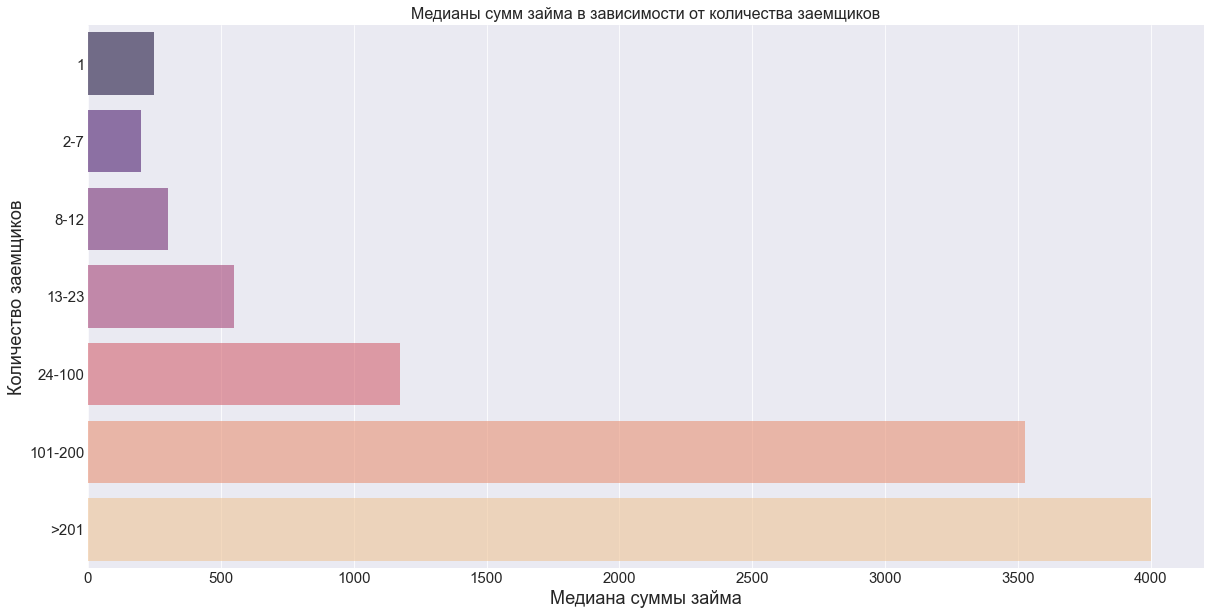

In [103]:
plt.figure(figsize=(20,10))
plt.title("Медианы сумм займа в зависимости от количества заемщиков", fontsize=16)
plt.tick_params(labelsize=15)
b = sns.barplot(y=df_sum_median.index, x = 'median' , data=df_sum_median, alpha=0.6,  palette = 'magma')
b.set_xlabel("Медиана суммы займа",fontsize=18)
b.set_ylabel("Количество заемщиков",fontsize=18)
plt.show()

**Вывод:** Прослеживается вполне четкая зависимость: чем больше количество заёмщиков, тем больше сумма крупных займов. 
Это представляется вполне логичным,поскольку большую сумму легче возвращать большому количеству людей. 
В то же время видно, что количество человек все же однозначно не предопределяет сумму займов, поскольку единичные крупные суммы встречаются и при меньшем количестве заемщков. Это скорее всего связано с тем, что более крупные займы обычно запрашивают небольшие группы людей для развития собственного бизнеса, а маленькие займы - для личных нужд, обеспечения питанием или совсем мелкого семейного бизнеса.

**Теперь найдем зависимость между сроком займа и количеством заемщиков.**

In [104]:
df_term_median = df_sorted\
   .groupby(['lender_count_group'])['term_in_months']\
   .agg(median = 'median')
df_term_median['group_position'] = df_term_median.index.map(sorted_valIndex)
df_term_median.sort_values(by = 'group_position',inplace=True)
df_term_median

,median,group_position
lender_count_group,,
1,8.0,1
2-7,8.0,2
8-12,12.0,3
13-23,14.0,4
24-100,14.0,5
101-200,13.0,6
>201,24.0,7


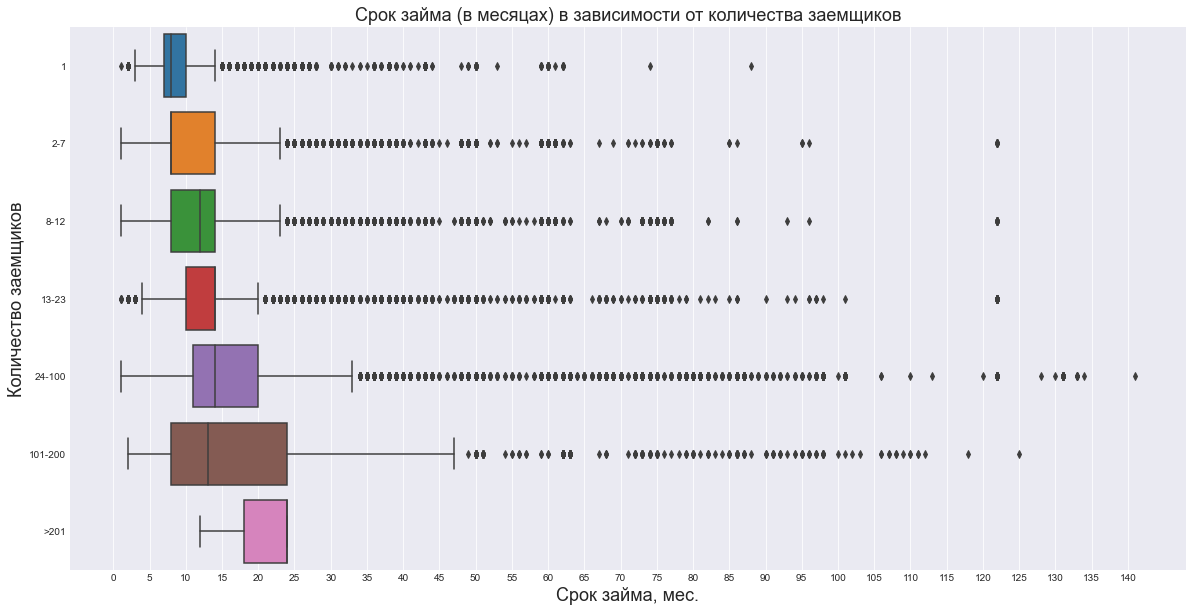

In [47]:
plt.figure(figsize=(20,10))
plt.title("Срок займа (в месяцах) в зависимости от количества заемщиков", fontsize=18)
plt.xticks(np.arange(0, max(df_sorted['term_in_months']), 5))
b = sns.boxplot(x='term_in_months', y="lender_count_group", data=df_sorted)
b.set_xlabel("Срок займа, мес.",fontsize=18)
b.set_ylabel("Количество заемщиков",fontsize=18)

plt.show()

*Построим аналогичный график для медианных значений:*

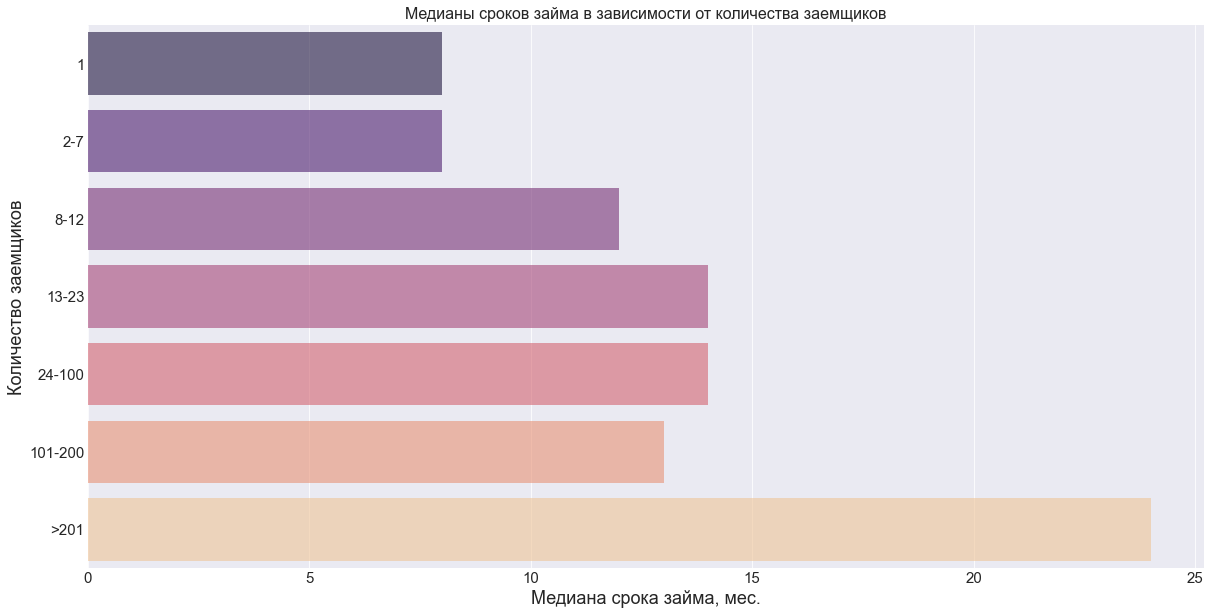

In [105]:
plt.figure(figsize=(20,10))
plt.title("Медианы сроков займа в зависимости от количества заемщиков", fontsize=16)
plt.tick_params(labelsize=15)
b = sns.barplot(y=df_term_median.index, x = 'median' , data=df_term_median, alpha=0.6,  palette = 'magma')
b.set_xlabel("Медиана срока займа, мес.",fontsize=18)
b.set_ylabel("Количество заемщиков",fontsize=18)
plt.show()

**Вывод:** Из диаграмм выше видно, что в целом срок займа больше для займов с большим количеством заемщиков. Это коррелирует с ранее обнаруженной зависимостью между количеством заемщиков и суммой займа. При большем количестве заемщиков сумма займа как правило больше, а время на его возвращение в связи с большой величиной возрастает.    
Судя по всему основная часть займов запрашивается на срок до 24 месяцев ( или 2-х лет). Визуально становится понятно, что преобладающая группа займов для всех групп заемщиков приобретается на промежуток между 10 и 15 месяцами.   


*Немного подробнее рассмотрим распределение срока займов в зависимости от количества заемщиков.*

In [48]:
df_loan_term = df_sorted.copy()

In [49]:
# Заменим все нулевые значения количества заемщиков: 
df_loan_term.loc[df_loan_term['lender_count'] < 1, 'lender_count'] = 1     

In [50]:
#Выведем основную информацию по итоговому датафрейму, чтобы оценить суммы для построения.
df_loan_term.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,MPI,group_position
count,6.558530e+05,655853.000000,655853.000000,645639.000000,655853.000000,655853.000000,584691.000000,655853.000000
mean,9.928668e+05,673.635510,715.067820,178.867366,13.649405,18.599128,0.130255,3.424591
std,1.968290e+05,680.983224,704.620596,94.068243,8.245540,18.943359,0.117405,1.243329
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,1.000000,0.000000,1.000000
25%,8.224450e+05,250.000000,275.000000,126.000000,8.000000,7.000000,0.053080,2.000000
50%,9.915990e+05,450.000000,475.000000,145.000000,13.000000,12.000000,0.061824,3.000000
75%,1.163975e+06,850.000000,925.000000,204.000000,14.000000,23.000000,0.209375,4.000000
max,1.340339e+06,4425.000000,4425.000000,533.000000,141.000000,268.000000,0.549778,7.000000


*Итак, по информации выше можно заметить что основная группа займов получена на срок от 8 до 14 месяцев заемщиками в количестве от 7 до 23 человек. Попробуем изобразить эту совокупность графически.*

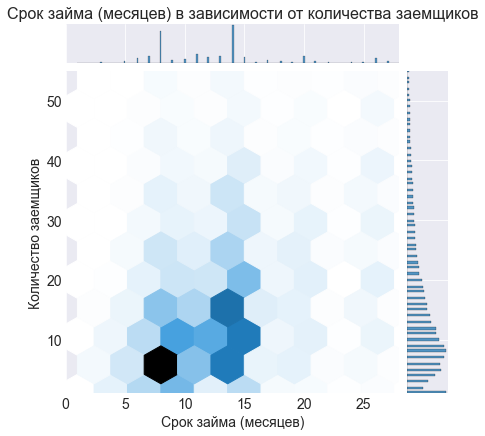

In [51]:
#Методом проб и ошибок был выявлен оптимальный интервал срока займа и количества заемщиков:
p = sns.jointplot(x="term_in_months", y="lender_count", data=df_loan_term, kind='hex', ylim=[1,55] , xlim=[0,28], ratio = 7)\
        .set_axis_labels("Срок займа (месяцев)", "Количество заемщиков", size=14)
p.ax_joint.tick_params(labelsize=14)
p.fig.suptitle("Срок займа (месяцев) в зависимости от количества заемщиков", size = 16)
p.fig.subplots_adjust(top=0.94)
plt.show()

**Вывод:** Больше всего займов было запрошено на срок от 6 до 10 месяцев заёмщиками в составе от 1 до 10 человек. Также много займов было запрошено заемщиками в группе от 10  до 20 человек на срок до 15 месяцев.   
Если обобщить, то можно сказать, что большая часть займов приходится на заемщиков в количестве от 1 до 20 человек, причем срок этих займов составляет от 5 до 17 месяцев.

**Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.**

In [52]:
df_kiva_loans

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,ISO,world_region,MPI
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,PAK,South Asia,0.233167
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2014-01-02 09:17:23+00:00,11.0,14,NaN,group,irregular,2014-01-01,PAK,South Asia,0.233167
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,IND,South Asia,0.000000
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01,PAK,South Asia,0.233167
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01,PAK,South Asia,0.233167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671200,1340323,0.0,25.0,Livestock,Agriculture,"[True, u'para compara: cemento, arenya y ladri...",PY,Paraguay,Concepción,USD,...,NaN,13.0,0,NaN,female,monthly,2017-07-25,NaN,NaN,NaN
671201,1340316,25.0,25.0,Livestock,Agriculture,"[True, u'to start a turducken farm.'] - this l...",KE,Kenya,NaN,KES,...,2017-07-26 02:09:43+00:00,13.0,1,NaN,female,monthly,2017-07-25,KEN,Sub-Saharan Africa,0.209375
671202,1340334,0.0,25.0,Games,Entertainment,NaN,KE,Kenya,NaN,KES,...,NaN,13.0,0,NaN,group,monthly,2017-07-26,KEN,Sub-Saharan Africa,0.209375
671203,1340338,0.0,25.0,Livestock,Agriculture,"[True, u'to start a turducken farm.'] - this l...",KE,Kenya,NaN,KES,...,NaN,13.0,0,NaN,female,monthly,2017-07-26,KEN,Sub-Saharan Africa,0.209375


In [53]:
df_kiva_loans.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,MPI
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000,590440.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922,0.130413
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551,0.117497
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000,0.053080
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000,0.061824
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000,0.209375
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000,0.549778


*Значения индекса MPI варьируются от 0.00 до 0.55*

In [54]:
sns.set_palette(sns.color_palette('gist_rainbow_r'))

In [55]:
df_MPI_sorted = df_kiva_loans_trimmed.sort_values(by = 'MPI')

In [56]:
df_MPI_sorted = df_MPI_sorted.dropna(subset=['MPI'])

In [57]:
df_MPI_sorted['MPI_r'] = df_MPI_sorted['MPI'].apply(lambda x : round(x,1))

In [58]:
df_MPI_sorted.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,MPI,MPI_r
count,5.846910e+05,584691.000000,584691.000000,576319.000000,584691.000000,584691.000000,584691.000000,584691.000000
mean,9.916542e+05,593.952669,629.134620,184.242154,13.312240,16.718448,0.130255,0.138373
std,1.972027e+05,585.998693,607.566627,89.272016,8.222353,17.014990,0.117405,0.117259
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000,0.000000,0.000000
25%,8.204655e+05,225.000000,250.000000,137.000000,8.000000,6.000000,0.053080,0.100000
50%,9.896930e+05,400.000000,425.000000,154.000000,13.000000,11.000000,0.061824,0.100000
75%,1.162988e+06,725.000000,800.000000,205.000000,14.000000,21.000000,0.209375,0.200000
max,1.340339e+06,4425.000000,4425.000000,533.000000,141.000000,172.000000,0.549778,0.500000


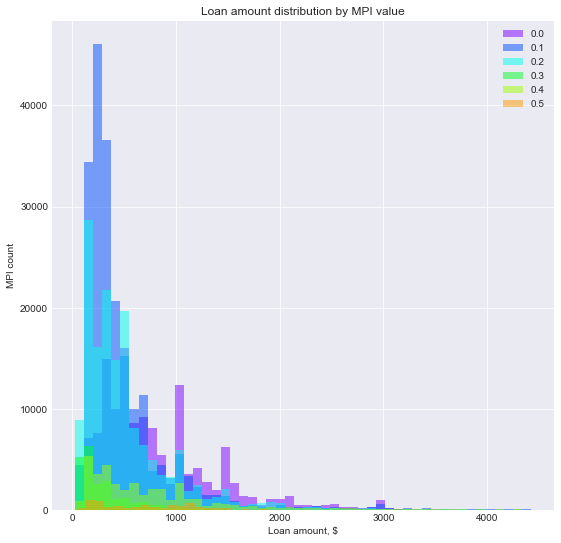

In [59]:
plt.figure(figsize=(9, 9))
for name, group in df_MPI_sorted.groupby(['MPI_r']):
    plt.hist(group['loan_amount'], label=name, bins=50, alpha=0.5)
plt.xlabel('Loan amount, $')
plt.ylabel('MPI count')
plt.title('Loan amount distribution by MPI value')
plt.legend()
plt.show()

*Нарисуем еще одну гистограмму, чтобы точнее оценить взаимоотношение между переменными:*

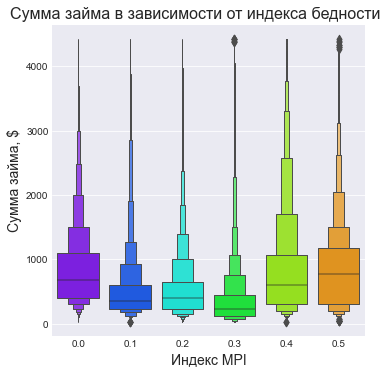

In [60]:
p = sns.catplot(y="loan_amount", x="MPI_r", kind="boxen", data=df_MPI_sorted)\
    .set_axis_labels("Индекс MPI", "Сумма займа, $", size=14)
p.fig.suptitle("Сумма займа в зависимости от индекса бедности", size = 16)
p.fig.subplots_adjust(top=0.93)
plt.show()

**Вывод:** Первая построенная нами диаграмма позволяет оценить количественное распределение значений с определенной суммой займа при разных уровнях индекса MPI. Так, четко видно, что больше всего займов в крупных суммах, да и больше зхаймов в целом пришлось на страны с уровнем MPI около 0.1. Также немало займов ( в т.ч. больших по сумме) было получено от заемщиков из стран с уровнем MPI равным 0.2. Меньше всего крупных займов получено от стран с индексами MPI 0.5, 0.4 и 0.3 соответственно, т.е. от наиболее бедных и нуждающихся стран.
Вторая диаграмма позволяет произвести структурный анализ займов в рамках одного уровня индекса MPI. Во-первых, становится заметно, что большая часть займов для всех категорий MPI находится в пределах 4-12 тыс.USD. Во-вторых,можно проанализировать, какие категории стран по MPI имеют наибольший разброс значений сумм займа. Это страны с наиболее высоким уровнем MPI (наиболее бедные) - суммы займов из подобных стран колеблются от 0 до 3200 долл.США. Наименьший разброс значений наблюдается в странах с уровнем MPI от 0.1 до 0.3, для которых суммы займов находятся  в пределах 1500- 1900 USD. 
Такие различия в структурном разбросе сумм займа в очередной раз доказывают, что займов от наиболее бедных стран меньше, чем займов от стран с индексами 0.1- 0.3. 

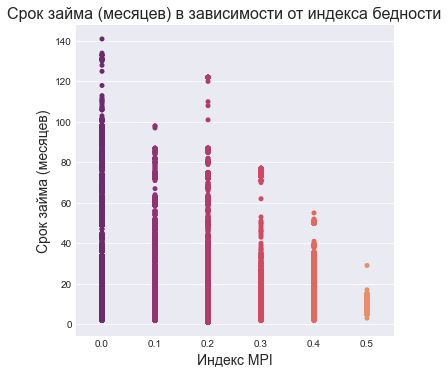

In [61]:
sns.set_palette(sns.color_palette('flare_r'))
p = sns.catplot(y="term_in_months", x="MPI_r", jitter=False, data=df_MPI_sorted)\
    .set_axis_labels("Индекс MPI", "Срок займа (месяцев)", size=14)
p.fig.suptitle("Срок займа (месяцев) в зависимости от индекса бедности", size = 16)
p.fig.subplots_adjust(top=0.93)
plt.show()

**Вывод:** По диаграмее выше можно проследить закономерность: чем выше уровень MPI (чем беднее страна), тем меньше срок займа. Частично это объясняется тем, что такие страны меньше запрашивают займы в особо крупных суммах (см. выше).
Поскольку одной из целей Kiva является финансирование буднейших стран и снижение уровня бедности, компании следовало бы пересмотреть свою политику для стран с наибольшим уровнем бедности. Для этого нужно в первую очередь усилить пристуствие компании в данных регионах, а именно увеличить количество партнеров в наиболее удаленных регионах, что позволит большему количеству людей подать заявку на займ через них (для них прямая подача через сайт недоступна в связи с недоступностью средств связи), а также позволит гораздо большему количеству нуждающихся людей узнать о существовании Kiva. 
Помимо этого, можно посоветовать компании пересмотреть условия предоставления займа для заявок из таких стран - например, посредством повышенного, по сравнению с другими странами, срока займа или предоставления кредитных каникул. 

**Рассмотрим зависимость ряда величин от макрорегиона, из которого поступил займ**

*Для этого, в первую очередь изучим соответствующий столбец с данныими макрорегионов и убедимся, что он заполнен корректно, а пропуски отсутствуют.*

In [62]:
df_kiva_loans_trimmed['world_region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Latin America and Caribbean',
       nan, 'East Asia and the Pacific', 'Arab States',
       'Europe and Central Asia'], dtype=object)

*В структуре данных присутствуют нулевые значения. Для целей детального исследования заменим их.*

In [63]:
df_kiva_loans_trimmed['world_region'].fillna("no_region", inplace = True)

D:\anaconda\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [64]:
no_region = df_kiva_loans_trimmed[df_kiva_loans['world_region'] == 'no_region']
no_region_list = no_region['country'].unique().tolist()

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [65]:
no_region_list.sort()
no_region_list

[]

*Получаем список стран, у колторых отсутствует значение макрорегиона. Соберем библиотеку, где ключ - страна, у которой отсутсвует значение макрорегиона; значение - искомый макрорегион в соответствии с ранее имеющимся списком + новое значене 'North America':*

In [66]:
replacement = ({'Bolivia': 'Latin America and Caribbean',
 'Chile': 'Latin America and Caribbean',
 'Congo': 'Sub-Saharan Africa',
 'Costa Rica': 'Latin America and Caribbean',
 "Cote D'Ivoire": 'Sub-Saharan Africa',
 'Georgia': 'Europe and Central Asia',
 'Guam': 'East Asia and the Pacific',
 'Israel': 'Europe and Central Asia',
 'Kosovo': 'Europe and Central Asia',
 'Lebanon': 'Arab States',
 'Moldova': 'Europe and Central Asia',
 'Myanmar (Burma)': 'East Asia and the Pacific',
 'Palestine': 'Arab States',
 'Panama': 'Latin America and Caribbean',
 'Paraguay': 'Latin America and Caribbean',
 'Puerto Rico': 'Latin America and Caribbean',
 'Saint Vincent and the Grenadines': 'Latin America and Caribbean',
 'Samoa': 'East Asia and the Pacific',
 'Solomon Islands': 'East Asia and the Pacific',
 'Tanzania': 'Sub-Saharan Africa',
 'The Democratic Republic of the Congo': 'Sub-Saharan Africa',
 'Turkey': 'Europe and Central Asia',
 'United States': 'North America',
 'Vietnam': 'East Asia and the Pacific',
 'Virgin Islands': 'Latin America and Caribbean'})

*Заменим значеня на нужные:*

In [67]:
def replace_values(c, r):
    if c in replacement.keys():
        val = replacement.get(c)
        r = val
    return r

In [68]:
df_kiva_loans_trimmed['world_region'] =[replace_values(c, r) for c, r in zip(df_kiva_loans_trimmed['country'], df_kiva_loans_trimmed['world_region'])]

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


*Проверка:*

In [69]:
df_kiva_loans_trimmed['world_region'].unique()

array(['South Asia', 'Sub-Saharan Africa', 'Latin America and Caribbean',
       'East Asia and the Pacific', 'Arab States', 'North America',
       'Europe and Central Asia'], dtype=object)

*Наконец, перейдем к графической части. Для начала построим график с распределением сумм займа по макрорегионам.*

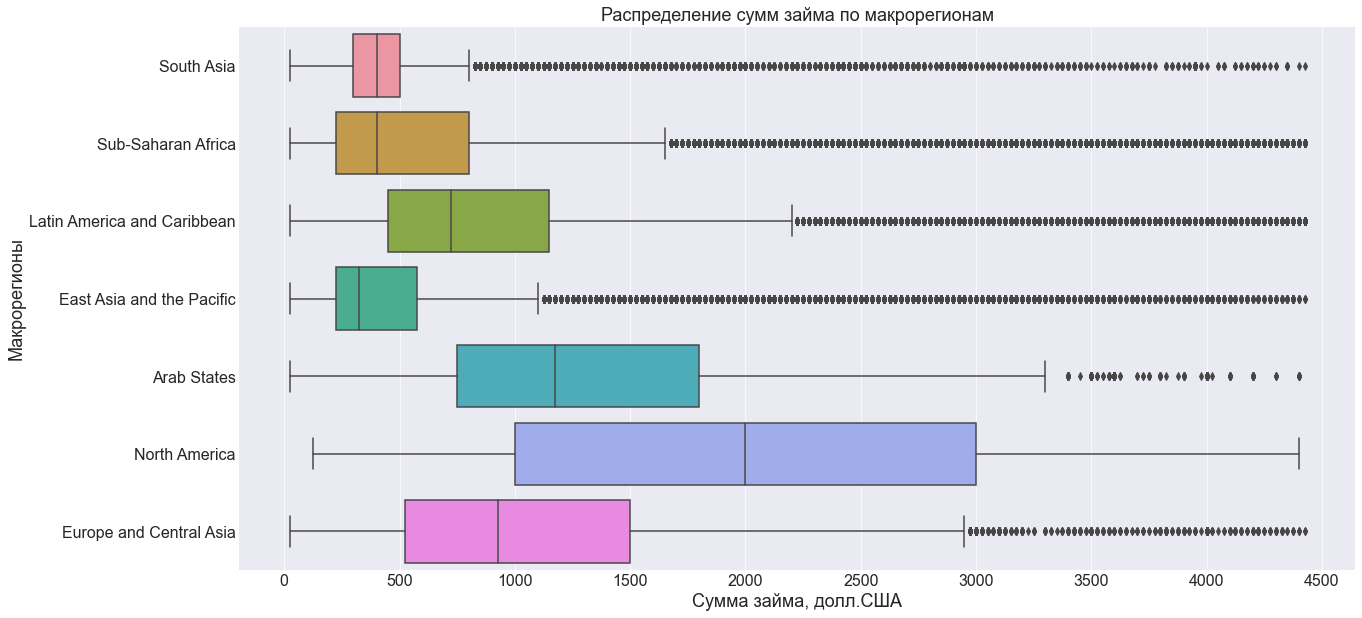

In [70]:
plt.figure(figsize=(20,10))
plt.title("Распределение сумм займа по макрорегионам", fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans_trimmed['loan_amount']+100), 500))
plt.tick_params(labelsize=16)
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
b= sns.boxplot(x='loan_amount', y="world_region", data=df_kiva_loans_trimmed)
b.set_xlabel("Сумма займа, долл.США",fontsize=18)
b.set_ylabel("Макрорегионы",fontsize=18)
plt.show()

**Вывод:** Есть четкое распределение сумм займов по макрорегионам. Наибольшее количество займов в маленькой сумме (до 800 долл.США) поступило от стран Южной Азии, Африки, а также Восточной Азии и Тихоокеанского региона, т.е. от наиболее бедных регионов. Самые большие суммы (от 800 до 3000 долл.США) пришлись на Арабские страны и Севреную Америку, как регионы с наименьшим количеством бедного населения.
На регионы Латинской Америки, Карибы, а также Европу и Центральную Азию приходятся займы в сумме от 500 до 1500 долл.США.

*Посмотрим на различие в сроках предоставления займа по регионам:*

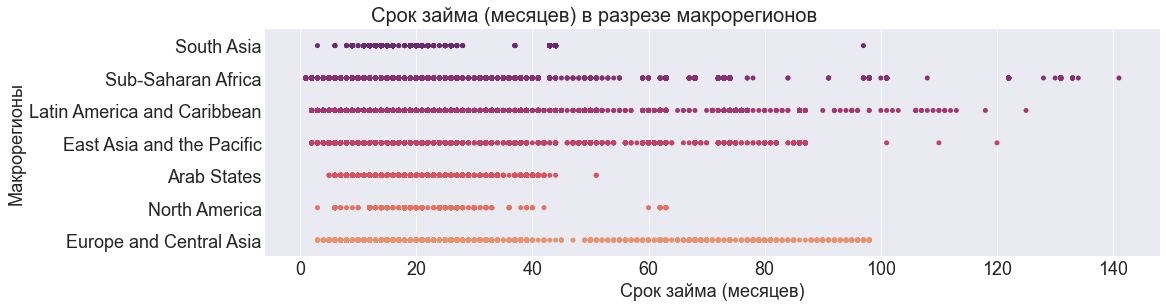

In [71]:
p = sns.catplot(x="term_in_months", y="world_region", jitter=False, data=df_kiva_loans_trimmed, height=4, aspect=4, 
                palette = 'flare_r')\
    .set_axis_labels("Срок займа (месяцев)","Макрорегионы", size=18)
p.fig.suptitle("Срок займа (месяцев) в разрезе макрорегионов", size = 20)
p.fig.subplots_adjust(top=0.9)
plt.show()

**Вывод:** Если сравнить распределение срока займа с макрорегионам с аналогичным распределением на диаграмее выше (с распределением  сумм), то можно заметить, что они во многом коррелируют между собой. Связано это с тем, что срок займа находится в прямой зависиомсти от суммы займа. Наименьший срок займа пришелся на страны с самыми низкими суммами займа, а также с самыми высокими суммами. Для первых стран маленький срок объясняется маленькой суммой займа, поскольку займы в тваких бедных странах обычно запрашиваются для ежедневных жизненных нужд. Краткий срок возврата займов в наибольших суммах объясняется тем, что в данных странах не самый высокий уровень бедности, а цель заимствования - либо вложения в бизнес (для стран Северной Америки), а также оплата дорогостоящего обучения (Арабские страны). Т.е. запрашиваются такие займы под единовременные платежи, которые население не может себе единовременно позводить, но вполне может вернуть через определенный период равными порциями.Стоит отметить, что для таких стран также характерно помесячное возвращение суммы долга, что также говорит о возможности людей накопит  нужную сумму в долгосрочной перспективе (см. ниже).
Из общей картины выбиваются лишь единичные займы с длительным сроком погашения, запрошенные из беднейших регонов Африки, Латинской Америки и Карибского регона, а также из стран Восточной Азии и Тихого океана. Наличие таких займов говорит о сложности совершения выплат для отдельных категорий населения в этих странах.

*Вспомогательные данные для вышеизложенных выводов:*

In [72]:
df_kiva_loans_trimmed[(df_kiva_loans_trimmed['world_region'] == 'North America') |
                      (df_kiva_loans_trimmed['world_region'] == 'Arab States') &
                     (df_kiva_loans_trimmed['loan_amount']> 1000)]['sector'].value_counts()

Services          3416
Education         3063
Food              2153
Retail            1846
Agriculture       1173
Clothing          1153
Personal Use      1093
Housing            943
Construction       447
Health             445
Transportation     426
Arts               360
Manufacturing      216
Entertainment      130
Wholesale           47
Name: sector, dtype: int64

In [73]:
df_kiva_loans_trimmed[(df_kiva_loans_trimmed['world_region'] == 'North America') |
                      (df_kiva_loans_trimmed['world_region'] == 'Arab States') &
                     (df_kiva_loans_trimmed['loan_amount']> 1000)]['repayment_interval'].value_counts()

monthly      15957
bullet         848
irregular      106
Name: repayment_interval, dtype: int64

*Обработаем исходные данные для полученя информации о сроках финансирования займа:*

In [74]:
# drop na (missing) values
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

D:\anaconda\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
D:\anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

*Построим диаграмму для определения зависимости сроков финансирования заявки от макрорегиона, 
из которого последняя поступила:*

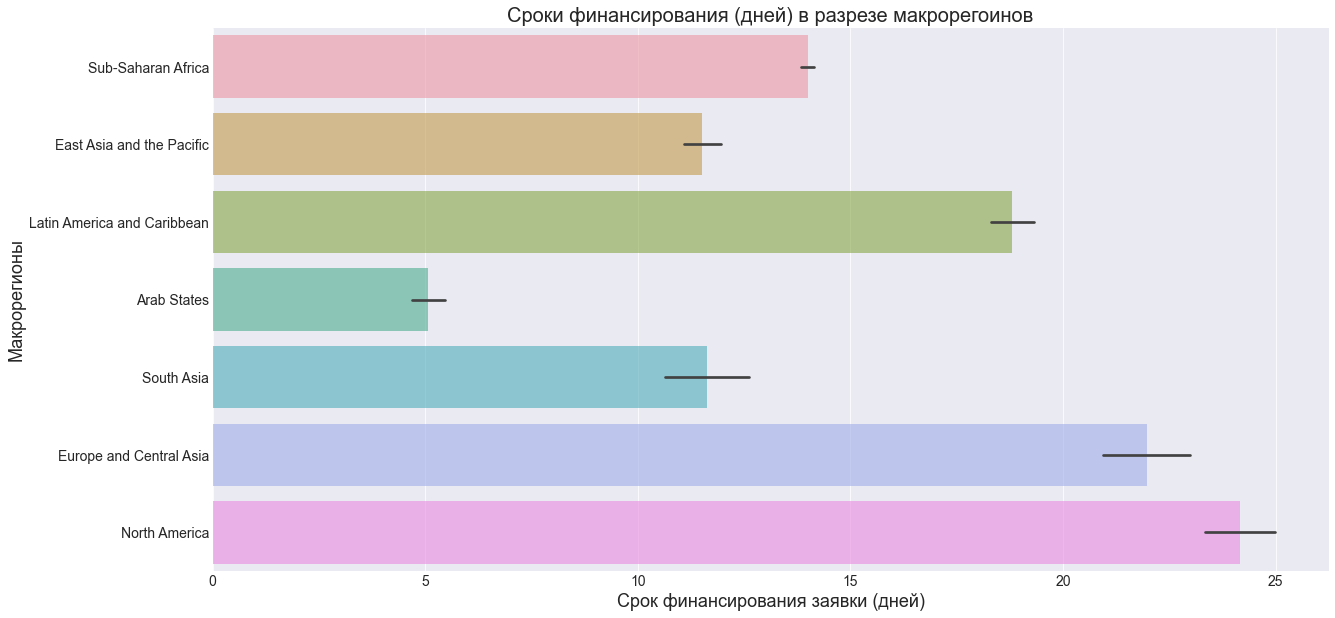

In [75]:
plt.figure(figsize=(20,10))
b = sns.barplot(y=df_loans_dates_trimmed['world_region'], x=df_loans_dates_trimmed['time_funding'], alpha=0.6)
b.axes.set_title("Сроки финансирования (дней) в разрезе макрорегоинов",fontsize=20)
b.set_xlabel("Срок финансирования заявки (дней)",fontsize=18)
b.set_ylabel("Макрорегионы",fontsize=18)
b.tick_params(labelsize=14)
plt.show()

**Вывод:** Распределение данных на гисторграмме позволяет судить о том, насколько равномерно проводится работа сервиса Kiva в разрезе макрорегионов. Максимальный срок финансирования заявок составляет  24 дня - достаточно маленький срок -  что говорит об эффективности сервиса в целом. В то же время анализ графических данных дает понять, что есть некая неравномерность в сроках финанисрования. Так, заявки из Арабских стран (напомним, одни из самых больших по суммам) финансируются в срок до 5 дней, в то время как заявки из регинов Европы, Центральной Азии и Северной Америки могут финансироваться более 20 дней. Это говорит о том, что работа сервиса организована не самым равномерным образом, из-за которого одни регионы получают средства раньше, чем другие.
Возможно компании стоит пересмотреть свою рекламную политику на сайте (освещать не только срочные заявки, но и заявки из наиболее нуждающихся регионов, те что требуются на поддержание достаточного уровня жизни и т.д.). Возможно компании также нужно увеличить количество своих представителей-посредников в таких регионах, что значительно упростит и сократит срок заявок.

*Далее рассмотрим распределение ежемесячных сумм платежа в разрезе макрорегионов. 
Как можно было заметить, есть три варианта выплат по займам - ежемесячные платежи, единоверменные платежи, а также нерегулярные выплаты (monthly, bullet и irregular соответственно). Для целей нашего анализа предположим, что все займы оплачиваются ежемесячно и заведем отдельный столбец 'Monthly_payment' путем простого деления суммы займа на срок в месяцах.*

In [76]:
df_loans_dates_trimmed['Monthly_payment']= df_loans_dates_trimmed['funded_amount']/df_loans_dates_trimmed['term_in_months']

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [77]:
df_loans_dates_trimmed.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,MPI,time_funding,Monthly_payment
count,2.798900e+04,27989.000000,27989.000000,23294.000000,27989.000000,27989.000000,26587.000000,27989.000000,27989.000000
mean,9.973826e+05,611.505413,611.505413,243.447325,14.938762,19.657508,0.200340,14.320215,50.560443
std,1.672924e+05,670.311692,670.311692,98.193205,12.986574,20.884818,0.086024,11.289711,57.763897
min,6.532750e+05,25.000000,25.000000,9.000000,1.000000,1.000000,0.000000,0.000069,1.315789
25%,8.582260e+05,200.000000,200.000000,164.000000,9.000000,7.000000,0.202833,4.769109,18.000000
50%,1.017685e+06,375.000000,375.000000,222.000000,13.000000,13.000000,0.209375,11.634722,40.384615
75%,1.090094e+06,750.000000,750.000000,301.000000,14.000000,24.000000,0.209375,23.755845,62.500000
max,1.334147e+06,4425.000000,4425.000000,504.000000,133.000000,184.000000,0.549778,40.555162,993.750000


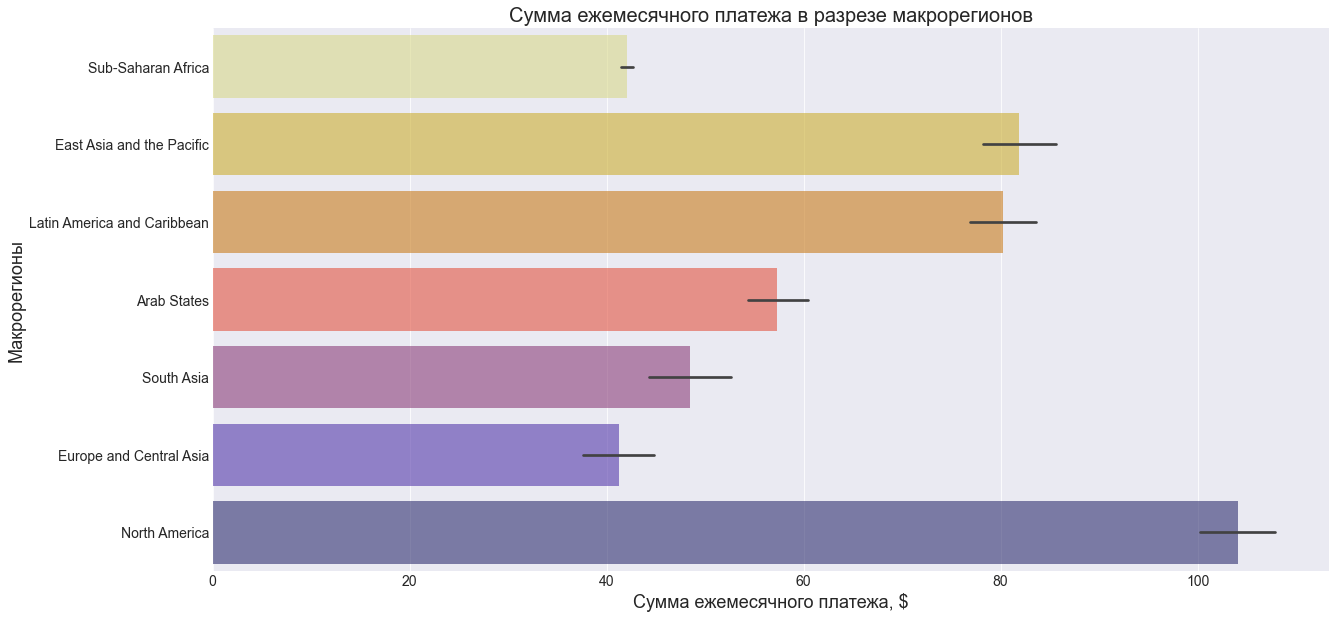

In [78]:
plt.figure(figsize=(20,10))
b = sns.barplot(y=df_loans_dates_trimmed['world_region'], x=df_loans_dates_trimmed['Monthly_payment'], alpha=0.6, 
                palette = 'CMRmap_r')
b.axes.set_title("Сумма ежемесячного платежа в разрезе макрорегионов",fontsize=20)
b.set_xlabel("Сумма ежемесячного платежа, $",fontsize=18)
b.set_ylabel("Макрорегионы",fontsize=18)
b.tick_params(labelsize=14)
plt.show()

**Вывод:** Наименьшие суммы ежемесячного платежа приходятся на страны регионов Африки, Европы, Центральной и Южной части Азии (до 50 долл. ежемесячно). До 60 долл.выплачивают жтели Арабских стран. Заемщики Восточной Азии, Тихоокеанского региона, Латинской Америки и Карибского бассейна возвращают порядка 80 долл.США в месяц. Наибольшая сумма выплат пришлась на Северную Америку - страну с наименьшим уровнем бедности. Выплаты составили до 110 долл.в мес. Из данной совокупности сложно сделать вывод. Придется все-таки разделить данные по форме выплаты задолженности (monthly, bullet, irregular).

*Попробуем провести подобный анализ только для стран, где платеж по факту ежемесячный.*

In [79]:
df_monthly = df_loans_dates_trimmed[df_loans_dates_trimmed['repayment_interval'] == 'monthly']

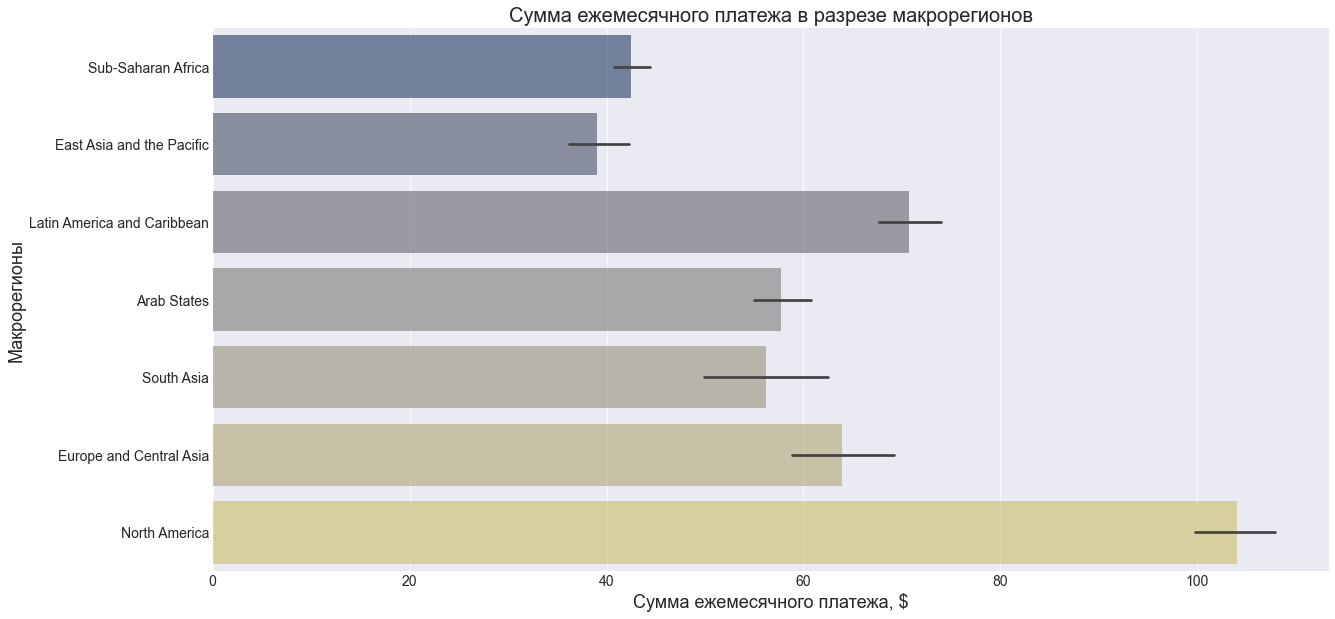

In [80]:
plt.figure(figsize=(20,10))
b = sns.barplot(y=df_loans_dates_trimmed['world_region'], x=df_monthly['Monthly_payment'], alpha = 0.6,
                palette = 'cividis')
b.axes.set_title("Сумма ежемесячного платежа в разрезе макрорегионов",fontsize=20)
b.set_xlabel("Сумма ежемесячного платежа, $",fontsize=18)
b.set_ylabel("Макрорегионы",fontsize=18)
b.tick_params(labelsize=14)
plt.show()

**Вывод:** Если остортировать данные, оставив только те, где указан ежемесячный способ возврата суммы займа, то можно проследить закономерность между суммой ежемесячных выплат, суммой платежа, а также сроком займа. Если сопоставить между собой соответствующие графики, то можно заметить, что самые большие ежемесячные суммы выплат приходятся на страны Северной Америки - страны с самыми большими суммами займов и самыми маленькими сроками их возвращения.        
    Самые маленькие суммы ежемесячных платежей приходятся на бедные страны Африки, Восточной Азии и Тихоокеанского региона.     Немного неожиданно, что по сумме ежемесячного платежа на втором месте после стран Северной Америки стоят страны Латинской Америки и Карибского бассейна, а не Арабские страны, как могло показаться, исходя из имеющихся данных. Возможно это объясняется наличием у населения Латинской Америки и Карибского бассейна средств от туристической составляющей экономики - это страны с достаточно большим притоком туристов в "летние" сезоны. В то же время отсутствие особо крупных выплат в Арабских странах объясняется тем, что займы получены в крупных суммах, а соответственно на более длительный срок.
    Выплаты из Арабских стран, Южной Азии, а также Европы и Центральной Азии находятся на примерно одинаковом уровне - до 60-62 долл.США в месяц.

*Чтобы обхватить все данные по выплатам, посмотртм также каким образом преимущественно выплачиваются займы в разных макрорегионах.*

In [81]:
df_payment_method = \
   df_loans_dates_trimmed\
    .groupby(['world_region', 'repayment_interval'])['repayment_interval']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('repayment_interval')\
    .fillna(0)\
    .sort_values(by=['monthly','bullet', 'irregular'], ascending = [True,True,False])

df_payment_method = df_payment_method[['monthly','bullet', 'irregular']]

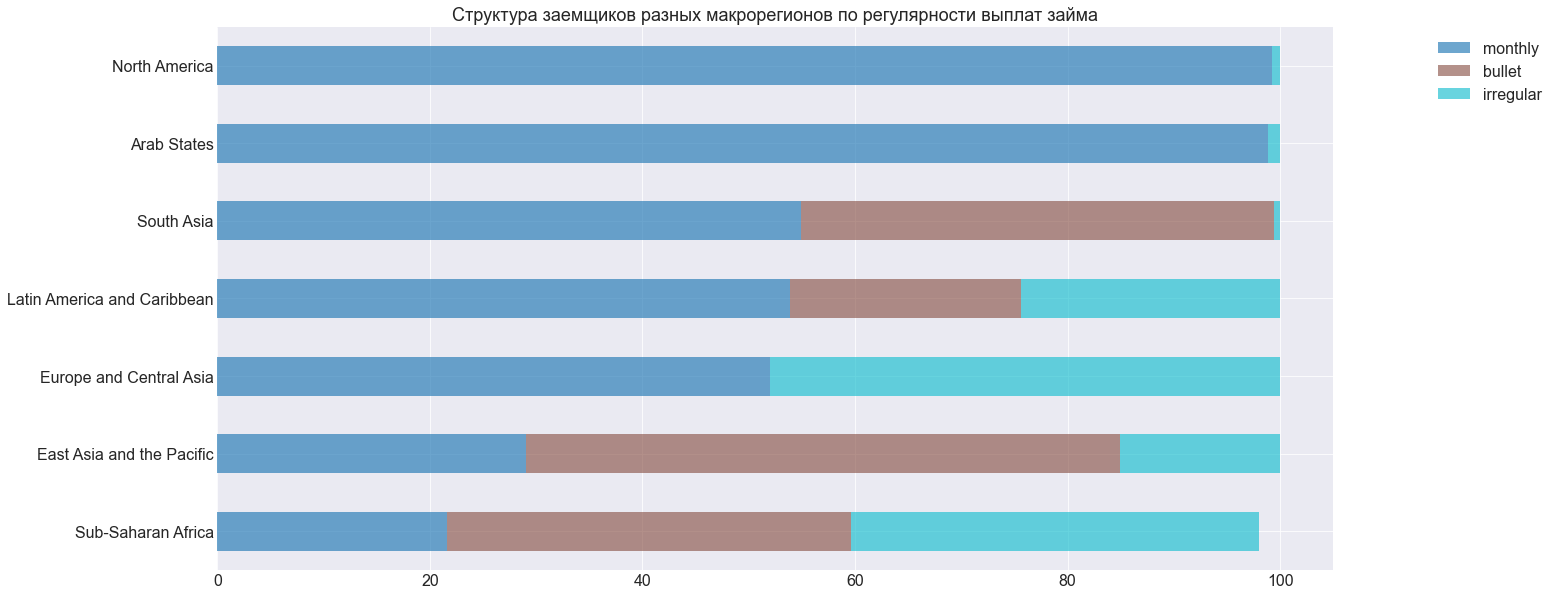

In [82]:
plot = df_payment_method.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Cтруктура заемщиков разных макрорегионов по регулярности выплат займа'
        , cmap = 'tab10'
        , alpha = 0.65)
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

**Вывод:** Структура заемщиков по способам выплат по займу также многое говорит о положении дел в различных макрорегионах планеты. Заметно, что в более богатых и стабильных странах выплаты производятся преимущественно ежемесячно (Северная Америка, Арабские страны). Нерегулярные платежи в то же время характерны для стран Европы и Центральной Азии, а также Африки, что говорит о наличие сложности постоянных выплат для части населения данных стран.
Также заметно, что заемщики из стран Восточной Азии и Тихоокеанского региона, Южной Азии (а также из ряда стран Африки и Латинской Америки) склонны возвращать суммы единовременным траншем по окончанию срока предоставления займа. С большой вероятностью это объясняется деятельностью посредников Kiva в данных регионах, через которых происходит передача средств от Kiva до заемщиков и обратно.